# Mapping the Role of Citrate Transporters in Solid Tumors
#### Exploring the Prevalence and Predictive Power of pmCiC Expression in Cancer Cells
*Authors: Blake Bleier, Tyler Gustafson* 

---

#### Project Summary

**Abstract**

Cancer cells undergo metabolic reprogramming to support rapid growth, including the potential increased uptake of citrate necessary for fatty acid synthesis. Recent studies suggest that cancer cells acquire extracellular citrate through a variant of the mitochondrial citrate transporter (SLC25A1), known as the plasma membrane citrate transporter (pmCiC). However, the systematic presence of pmCiC in tumors remains to be fully established. This project aims to investigate the prevalence and significance of pmCiC across various solid tumors by leveraging large-scale genomics data from The Cancer Genome Atlas (TCGA). We will conduct differential splicing analysis on primary tumors and matched normal tissues and apply a linear regression-based deconvolution approach to assess pmCiC expression in cancer cells relative to stromal cells. Additionally, a machine learning model will be developed to predict tumor grade based on pmCiC expression, which has been associated with tumor grade. This research may improve our understanding of cancer metabolism and highlight potential therapeutic targets.

**Hypothesis:** 

*Cancer cells express plasma membrane variant (pmCiC) of the citrate transporter gene SLC25A1, whereas the normal cell express the mitochondrial (mCiC) variant.  The proportion of pmCiC to mCiC is hypothesized to be higher in cancer cells than in normal cells.* 

**Objectives:**

- Analyze TCGA data by comparing splicing patterns in primary solid tumors and normal tissue across tumor types.
- Investigate subtype analysis for tissues of interest to detect underlying subtype correlations with pmCiC expression
- Develop a machine learning model to predict tumor grade using the pmCiC expression as a feature.


#### Contents

- 0 | *Clinical Overview: Cancer Metabolism and pmCiC*

- 1 | *Data Ingestion*

- 2 | *Exploratory Data Analysis (EDA)*

- 3 | *Statistical Analysis*

- 4 | *Phenotypic Subtype Analysis*

- 5 | *Revisit Statistical Analysis (Phenotypic Data)*

- 6 | *Linear Deconvolution*

- 7 | *Survival Analysis*

- 8 | *Summary and Next Steps*

- 9 | *Acknowledgements*

**Appendix**
- A1 | *Machine Learning Model(s)*

## **0. Clinical Overview: Cancer Metabolism and pmCiC**

Cancer cells undergo metabolic reprogramming to support rapid growth and proliferation. Unlike normal cells, which rely on glycolysis and mitochondrial oxidative phosphorylation, cancer cells exploit alternative pathways to fuel biosynthesis and energy production. Citrate, a key intermediate in the tricarboxylic acid (TCA) cycle, is crucial for lipid synthesis and energy storage. Cancer cells acquire extracellular citrate via a plasma membrane-specific variant of the mitochondrial citrate transporter (SLC25A1), known as pmCiC, which enables citrate uptake from the microenvironment.

#### Role of Alternative Splicing

Alternative splicing generates the pmCiC isoform, allowing its localization to the plasma membrane. This splicing event may be dysregulated in cancer cells, potentially facilitating increased citrate uptake to meet the biosynthetic demands of tumor growth.

#### Implications for Research and Therapy

Understanding pmCiC's expression and regulation could identify it as a diagnostic biomarker or therapeutic target. Targeting pmCiC may disrupt citrate uptake, impair tumor metabolism, and slow cancer progression. This project leverages TCGA data to investigate pmCiC’s role in cancer, exploring its expression, splicing patterns, and potential contributions to tumor progression.


---

## **1. Data Ingestion**

Before diving into the analysis, it's important to properly ingest the data to ensure its integrity and usability. This section handles all our imports and involves loading the dataset, validating its structure, and calculating any ratios for investigation.

**Transcript Information**
- NM_001256534.2: pmCiC (tricarboxylate transport protein, mitochondrial isoform b)
- NM_001287387.2: mCIC (tricarboxylate transport protein, mitochondrial isoform c)
- NM_005984.5: mCIC (tricarboxylate transport protein, mitochondrial isoform a precursor)
- ENSG00000100075: Ensembl Gene ID for SLC25A1 

#### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import scikit_posthocs as sp
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier

from sksurv.util import Surv
from sksurv.nonparametric import kaplan_meier_estimator

# Set the option to display all columns
pd.set_option('display.max_columns', None)

# Supress warning messsages for cleaner visualization
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Insert file paths for data files here
ISOFORM_FILE_PATH = 'data/isoform.csv'
PATIENT_SUPP_INFO_FILE_PATH = 'data/patient_supp_info'
IMMUNE_FILE_PATH = 'data/immune_supp_info.csv'
MOLECULAR_FILE_PATH = 'data/molecular_supp_info.csv'
SAMPLE_TYPE_FILE_PATH = 'data/sample_type_supp_info.csv'
PURITY_FILE_PATH = 'data/purity.csv'

#### Load Files

In [4]:
df = pd.read_csv(ISOFORM_FILE_PATH).drop(columns='Unnamed: 0')

# Remove LAML (Acute Myeloid Leukemia) as we are only interested in solid tumors
df = df[df['disease_type'] != 'LAML']

In [5]:
df.head(2)

,FileName,NM_001256534.2_Read_Counts,NM_001256534.2_TpM,NM_001287387.2_Read_Counts,NM_001287387.2_TpM,NM_005984.5_Read_Counts,NM_005984.5_TpM,ENSG00000100075,tcga_merge_name,tissue_type,disease_type,source_type
0,TCGA-FV-A3I0-11A-11R-A22L-07_c8a84054-d6cd-45b...,316.2415,7.4,1426.2735,36.7,5038.4850,126.2,136.5,TCGA-FV-A3I0-11,liver,LIHC,TCGA_normal
1,TCGA-62-8394-01A-11R-2326-07_11d49add-1b81-436...,428.0903,14.1,2671.5974,96.7,7397.2906,260.8,304.5,TCGA-62-8394-01,lung,LUAD,TCGA_cancer


In [6]:
df.tail(2)

,FileName,NM_001256534.2_Read_Counts,NM_001256534.2_TpM,NM_001287387.2_Read_Counts,NM_001287387.2_TpM,NM_005984.5_Read_Counts,NM_005984.5_TpM,ENSG00000100075,tcga_merge_name,tissue_type,disease_type,source_type
7373,TCGA-75-6212-01A-11R-1755-07_b30652fe-2914-420...,30.2584,1.5,1179.2011,62.3,1014.5405,52.3,93.2,TCGA-75-6212-01,lung,LUAD,TCGA_cancer
7374,TCGA-B0-5694-01A-11R-1541-07_94008843-2c57-446...,53.5182,2.4,1272.6842,61.5,1333.7976,62.9,82.2,TCGA-B0-5694-01,kidney,KIRC,TCGA_cancer


### Summary Stats

In this section we look into preliminary details about the dataset, such as available columns, data types, and missing data

In [7]:
print(df.columns)
print(f'\nThere are {len(df.columns)} columns and {len(df)} rows in the dataset')

Index(['FileName', 'NM_001256534.2_Read_Counts', 'NM_001256534.2_TpM',
       'NM_001287387.2_Read_Counts', 'NM_001287387.2_TpM',
       'NM_005984.5_Read_Counts', 'NM_005984.5_TpM', 'ENSG00000100075',
       'tcga_merge_name', 'tissue_type', 'disease_type', 'source_type'],
      dtype='object')

There are 12 columns and 7252 rows in the dataset


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7252 entries, 0 to 7374
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FileName                    7252 non-null   object 
 1   NM_001256534.2_Read_Counts  7252 non-null   float64
 2   NM_001256534.2_TpM          7252 non-null   float64
 3   NM_001287387.2_Read_Counts  7252 non-null   float64
 4   NM_001287387.2_TpM          7252 non-null   float64
 5   NM_005984.5_Read_Counts     7252 non-null   float64
 6   NM_005984.5_TpM             7252 non-null   float64
 7   ENSG00000100075             7252 non-null   float64
 8   tcga_merge_name             7252 non-null   object 
 9   tissue_type                 7252 non-null   object 
 10  disease_type                7252 non-null   object 
 11  source_type                 7252 non-null   object 
dtypes: float64(7), object(5)
memory usage: 736.5+ KB


In [9]:
df.describe()

,NM_001256534.2_Read_Counts,NM_001256534.2_TpM,NM_001287387.2_Read_Counts,NM_001287387.2_TpM,NM_005984.5_Read_Counts,NM_005984.5_TpM,ENSG00000100075
count,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000
mean,128.451258,3.840651,1764.973070,57.664189,2417.533840,75.746760,109.100731
std,109.529153,3.014127,1353.978646,41.587871,1874.517726,51.180133,57.348721
min,1.694200,0.300000,12.079600,0.700000,21.082400,1.800000,4.200000
25%,55.492900,1.800000,907.240975,31.400000,1232.212675,42.800000,71.900000
50%,101.394000,3.100000,1427.103200,48.350000,1965.099450,64.400000,96.150000
75%,170.289700,5.000000,2193.011850,71.600000,3055.160750,95.525000,133.100000
max,2114.781800,44.600000,16916.214700,520.400000,34498.883200,858.500000,855.000000


In [10]:
df.isna().sum()

FileName                      0
NM_001256534.2_Read_Counts    0
NM_001256534.2_TpM            0
NM_001287387.2_Read_Counts    0
NM_001287387.2_TpM            0
NM_005984.5_Read_Counts       0
NM_005984.5_TpM               0
ENSG00000100075               0
tcga_merge_name               0
tissue_type                   0
disease_type                  0
source_type                   0
dtype: int64

In [11]:
df.duplicated().sum()

10

In [12]:
df.nunique()

FileName                      7242
NM_001256534.2_Read_Counts    7231
NM_001256534.2_TpM             190
NM_001287387.2_Read_Counts    7240
NM_001287387.2_TpM            1488
NM_005984.5_Read_Counts       7240
NM_005984.5_TpM               1802
ENSG00000100075               2244
tcga_merge_name               7237
tissue_type                     19
disease_type                    25
source_type                      2
dtype: int64

In [13]:
df.dtypes

FileName                       object
NM_001256534.2_Read_Counts    float64
NM_001256534.2_TpM            float64
NM_001287387.2_Read_Counts    float64
NM_001287387.2_TpM            float64
NM_005984.5_Read_Counts       float64
NM_005984.5_TpM               float64
ENSG00000100075               float64
tcga_merge_name                object
tissue_type                    object
disease_type                   object
source_type                    object
dtype: object

##### Summary of preliminary EDA:  
- No duplicate data
- No missing values in the dataset
- 5 non-numeric features including file names, source type, tissue type
- NM_**** corresponds to specific isoforms of the citrate transporter
    - dataset contains raw read counts and TpM data

---

## **2. Exploratory Data Analysis (EDA)**

Now that we have done a quick runthrough of the data and there are no major issues identified, we can begin exploring the data.  There are three isoforms of the SLC25A1 gene:
- NM_001256534.2: pmCiC (tricarboxylate transport protein, mitochondrial isoform b)
- NM_001287387.2: mCIC (tricarboxylate transport protein, mitochondrial isoform c)
- NM_005984.5: mCIC (tricarboxylate transport protein, mitochondrial isoform a precursor)

We are particulaly interested in proporition of the pmCiC isoform (NM_001256534.2) relative to the total gene expression, but will begin by exploring all three isoform data.

### Histograms of Isoform Expression

We begin by viewing the histogram data of for a given isoform.

Note: To view a different isoform, change the `isoform=isoforms[0]` code in the cell below.

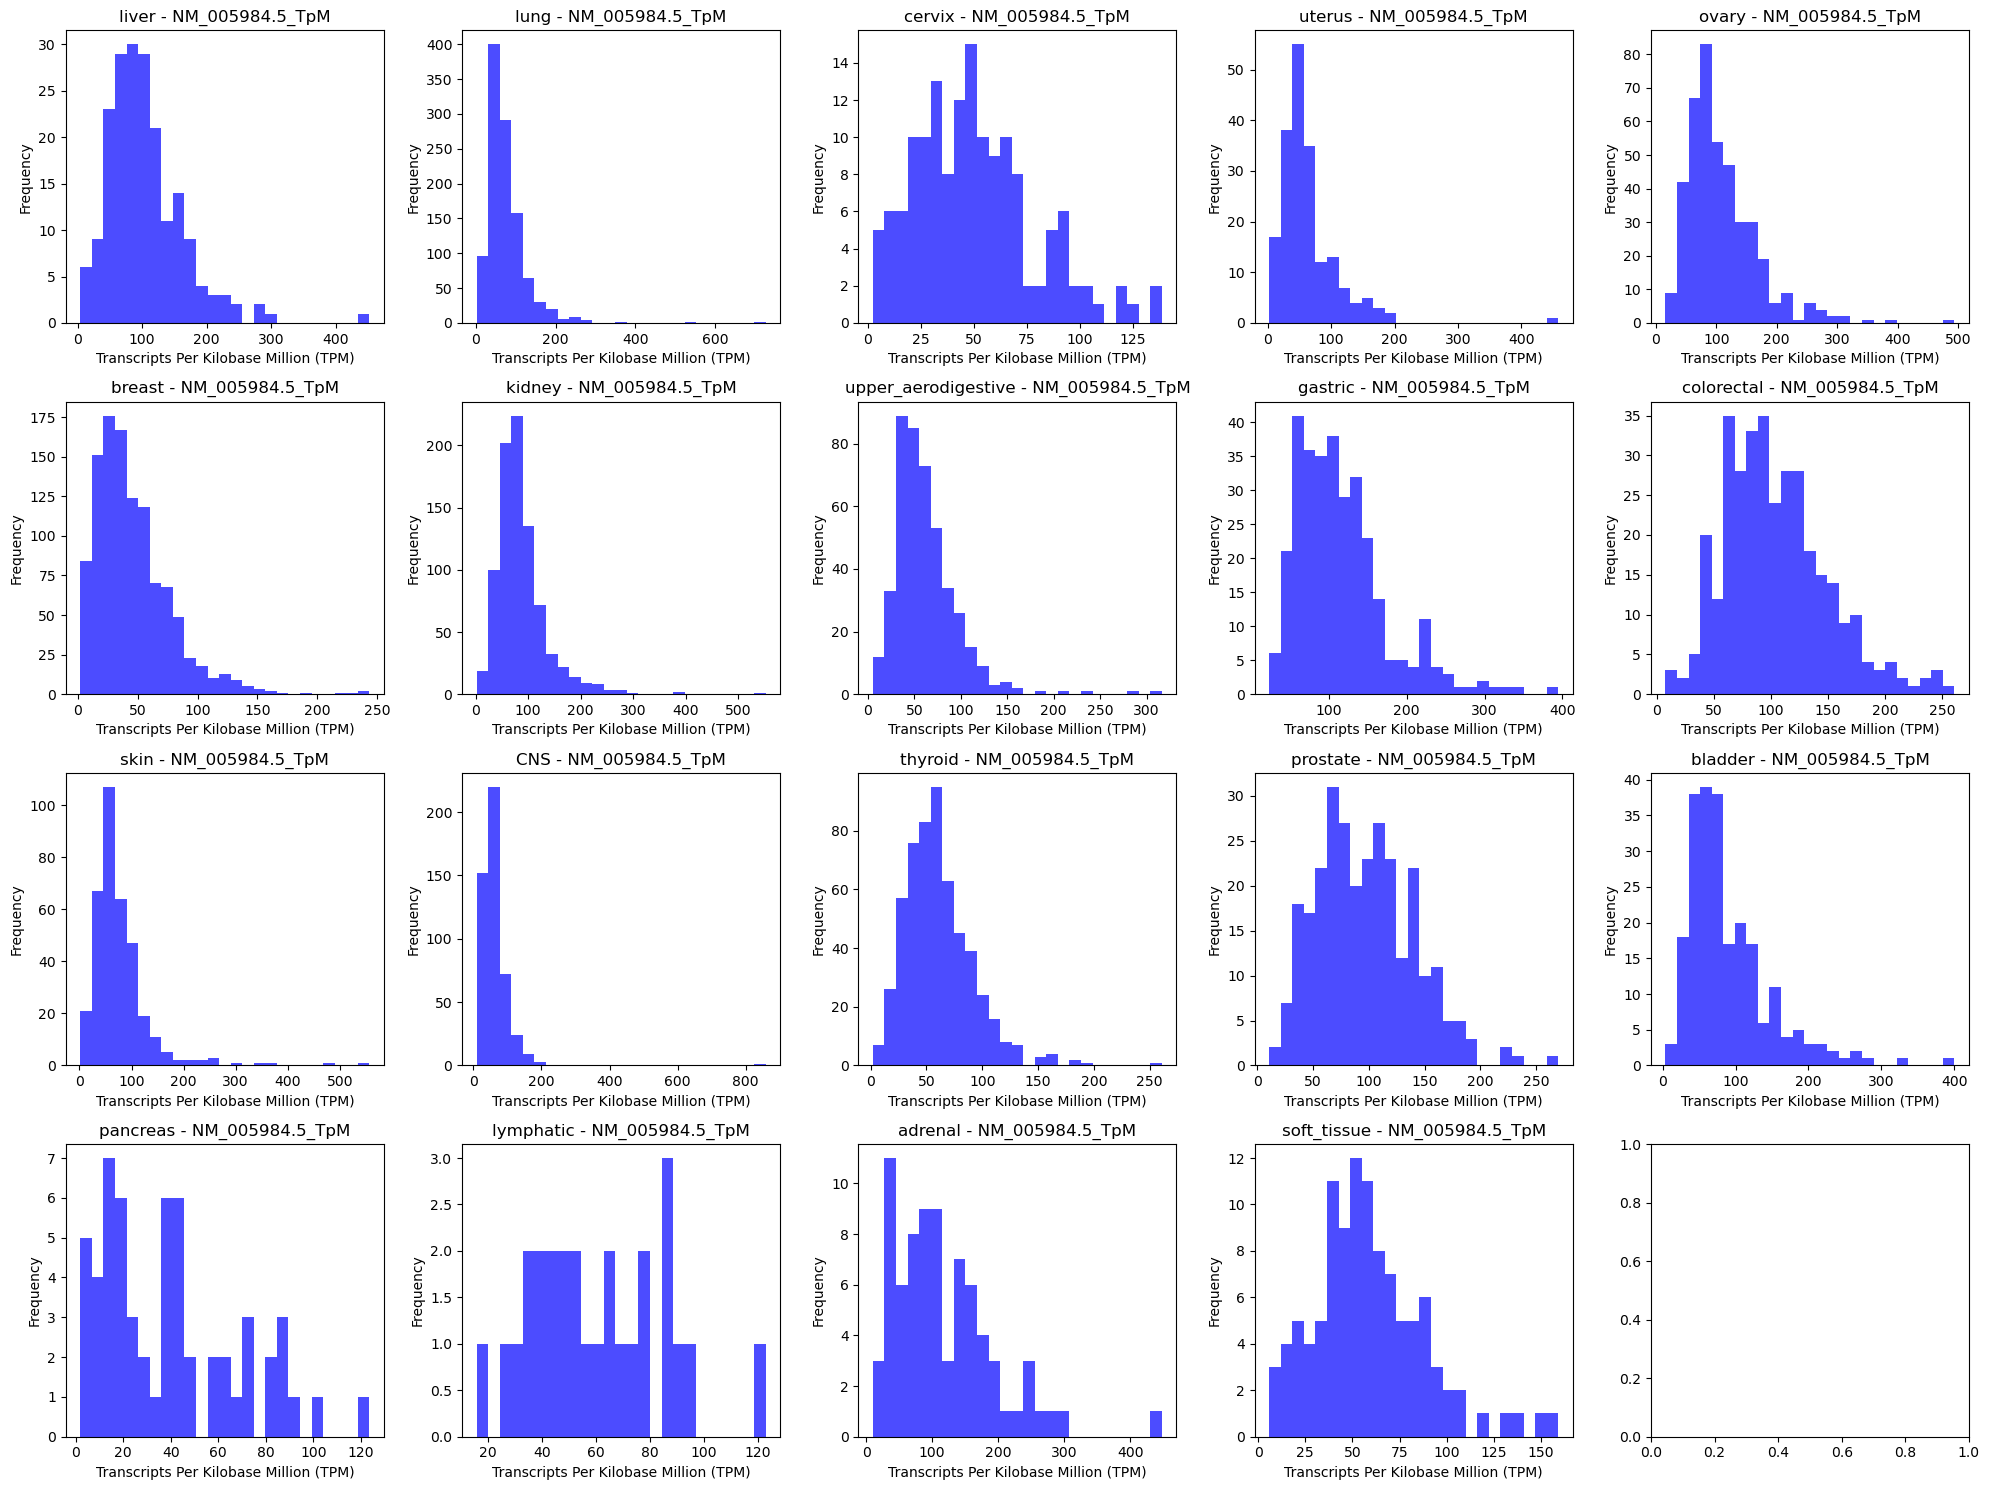

In [14]:
# Select the isoform to be plotted
isoforms = ['NM_005984.5_TpM', 'NM_001287387.2_TpM', 'NM_001256534.2_TpM']
isoform = isoforms[0]

# Cancer data only
# Select tissue 
tissue_types = df['tissue_type'].unique()

fig, axes = plt.subplots(4, 5, figsize=(20, 15))  # 4 rows, 5 columns for 20 tissue types
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each tissue type and create a histogram
for i, tissue in enumerate(tissue_types):
    tissue_data = df[df['tissue_type'] == tissue][isoform]
    
    # Plot the histogram in the respective subplot
    axes[i].hist(tissue_data, bins=25, alpha=0.7, color='b')
    axes[i].set_title(f"{tissue} - {isoform}")
    axes[i].set_xlabel('Transcripts Per Kilobase Million (TPM)')
    axes[i].set_ylabel('Frequency')

# Adjust the layout so plots do not overlap
plt.tight_layout()

**Summary:**

While some of the data is normal, a large proportion of the tissue types are right skewed due to some samples with abnormally high expression.

### Tissue Distribution
We want to determine the amount of data we have for each tissue type, comparing both cancer and control samples.

In [15]:
# Group data by tissue type and by source type
df_tissue_grouped = df.groupby(['tissue_type', 'source_type'])
df_tissue = df_tissue_grouped.size().unstack(fill_value=0)
df_tissue.sort_values('TCGA_cancer', ascending=False, inplace=True)

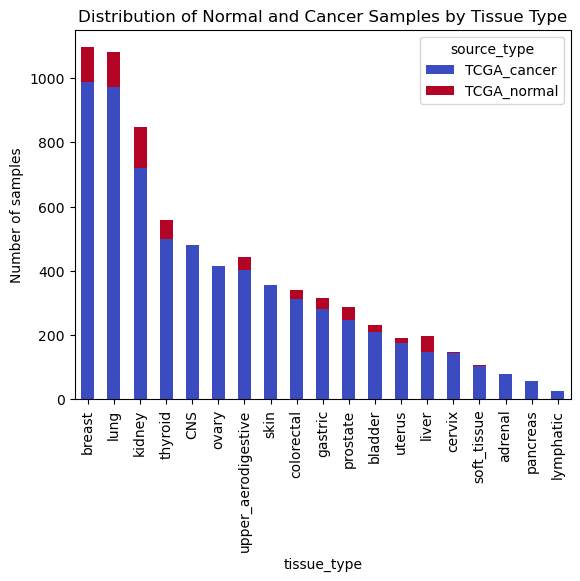

There are 19 types of cancer in the dataset


In [16]:
# Plot the tissue type distribution
df_tissue.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Distribution of Normal and Cancer Samples by Tissue Type')
plt.ylabel('Number of samples')
plt.xticks(rotation=90)
plt.show()

print(f'There are {len(df_tissue)} types of cancer in the dataset')

#### Filter to Tissue Types with >30 Control Samples

In [17]:
# Number of control samples by tissue type
df[df['source_type'] == 'TCGA_normal']['tissue_type'].value_counts()

tissue_type
kidney                 126
lung                   108
breast                 107
thyroid                 58
liver                   50
prostate                43
upper_aerodigestive     39
gastric                 33
colorectal              28
bladder                 19
uterus                  17
cervix                   3
pancreas                 2
soft_tissue              2
Name: count, dtype: int64

Although most tissue types have some control samples, many of them do now have enough samples for a solid statistical analysis.  We are trimming our dataset to tissue types that contain at least 30 control samples to have a high enough n value

In [18]:
# Select tissue based on having at least 30 control samples
tissue_control_samples = df[df['source_type'] == 'TCGA_normal']['tissue_type'].value_counts()
selected_tissues = list(tissue_control_samples[tissue_control_samples >= 30].index)

In [19]:
# Filter the dataframe accordingly
df = df[df['tissue_type'].isin(selected_tissues)].reset_index(drop=True)
print(f'Remaining samples after filtering is: {len(df)}')

Remaining samples after filtering is: 4824


### Investigate Disease Type

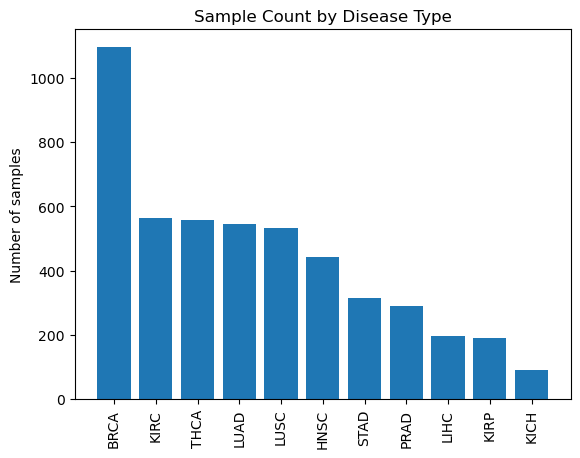

There are 11 types of cancer in the dataset


In [20]:
df_disease = df['disease_type'].value_counts()

plt.bar(df_disease.index, df_disease.values)
plt.title('Sample Count by Disease Type')
plt.ylabel('Number of samples')
plt.xticks(rotation=90)
plt.show()

print(f'There are {len(df_disease)} types of cancer in the dataset')

### Correlation Matrix

We want to see how the different isoform TpM expression levels are correlated with one another.

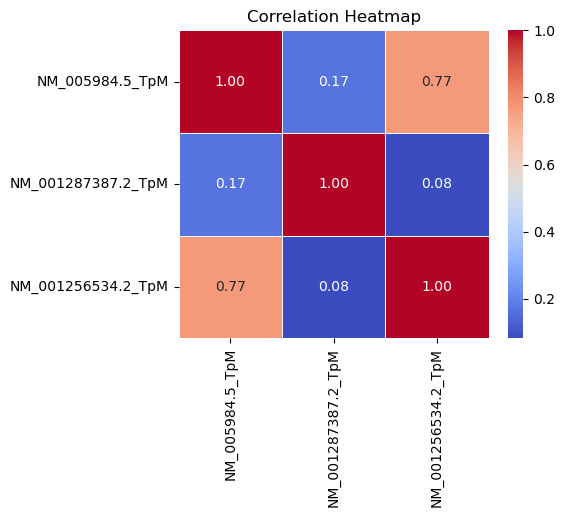

In [21]:
# Calculate the correlation matrix
corr_matrix = df[isoforms].corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(5, 4))  
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Heatmap')
plt.show()

The main mCiC isoform (`NM_005984.5`) and the pmCiC isoform (`NM_001256534.2`) are highly correlated.  This is another reason we will be looking at proportion instead of raw TpM value for the pmCiC isoform.

### Tumor vs Control Expression Levels Based on TpM

We will start out exploring visually how expression levels change for each individual isoforms across tissue types.  We will use TpM counts for this analysis.  Later in the document, we will convert the data to proportion of pmCiC to perform statistical analyses, but in this section we are interested in a general understanding of the data.

#### Plot by Tissue Type

In [22]:
def prep_and_melt_data(df, isoforms, stat_types = ['mean', 'median', 'std']):
    '''Take a dataframe and a list of isoforms and stats of interest and converts into
    an isoform summary df, and a melted summary df for easy plotting'''

    # Group the proportions by tissue type and source type.  Find the mean and stdev for each isoform.
    isoform_summary = df.groupby(['tissue_type', 'source_type'])[
    isoforms].agg(stat_types).reset_index()

    # Rename the columns to compress the df
    # Check if the second level column exists.  If so, join levels.
    isoform_summary.columns = ['_'.join(col).strip() if col[-1] != '' else col[0] for col in isoform_summary.columns]

    # Create list of value variable names for melted_df
    value_vars = [isoforms[i] + '_' + stat_types[j] for i in range(len(isoforms)) for j in range(len(stat_types))]

    # Melt the dataframe to turn it from horizontal to vertical
    melted_df = isoform_summary.melt(
        id_vars=['tissue_type', 'source_type'],  # Keep tissue_type and source_type as identifiers
        value_vars=value_vars, 
        var_name='isoform_stat',  # Name for the isoform and stat combined column
        value_name='value'  # Name for the value column (mean or std)
    )

    return isoform_summary, melted_df

isoform_summary_df, melted_df = prep_and_melt_data(df, isoforms)

In [23]:
def plot_cancer_vs_normal_barplots(melted_df, isoforms, isoform_summary_df, wilcox_df = None, rows = 2, columns = 3, plot_median = True, figsize = (18,12), 
                                   y_label = 'TPM (Mean)', title_size=15):
    '''Plots the mean and median of normal cells vs cancer cells, separated by tissue type, for 
    each individual isoform'''

    # Set up the figure
    fig, axes = plt.subplots(rows, columns, figsize=figsize)

    # Convert axes to at least 2D, even if rows=1 or columns=1
    axes = np.atleast_2d(axes)

    for i, isoform in enumerate(isoforms):
        # Isolate the mean, median, and std data
        mean_data = melted_df[melted_df['isoform_stat'] == f'{isoform}_mean']
        median_data = melted_df[melted_df['isoform_stat'] == f'{isoform}_median']
        std_data = melted_df[melted_df['isoform_stat'] == f'{isoform}_std']
        
        # Ensure NaN values are filled with 0 in std_data
        std_data.loc[std_data['value'].isna(), 'value'] = 0

        ## Plot the top row (Mean data)
        # Plot the barplot without error bars
        barplot_mean = sns.barplot(ax=axes[0, i], data=mean_data, x='tissue_type', y='value', hue='source_type', 
                                hue_order=['TCGA_normal', 'TCGA_cancer'], palette='viridis', errorbar=None)

        # Get the x positions of the bars for plotting error bars
        offsets = [bar.get_x() + bar.get_width() / 2 for bar in barplot_mean.patches]

        # Split the offsets for cancer and normal
        half_way = int(len(mean_data) / 2)
        normal_positions = offsets[0:half_way]
        cancer_positions = offsets[half_way:]

        # Add error bars for normal cells (Mean)
        normal_data = isoform_summary_df[isoform_summary_df['source_type'] == 'TCGA_normal']
        axes[0, i].errorbar(
            x=normal_positions,
            y=normal_data[f'{isoform}_mean'].values,
            yerr=normal_data[f'{isoform}_std'].values,
            fmt='none', color='navy', capsize=5,
            label='Normal Error Bars'
        )

        # Add error bars for cancer cells (Mean)
        cancer_data = isoform_summary_df[isoform_summary_df['source_type'] == 'TCGA_cancer']
        axes[0, i].errorbar(
            x=cancer_positions,
            y=cancer_data[f'{isoform}_mean'].values,
            yerr=cancer_data[f'{isoform}_std'].values,
            fmt='none', color='darkgreen', capsize=5,
            label='Cancer Error Bars'
        )


        # Set titles and labels for mean data
        axes[0, i].set_title(f'{isoform} (Mean)', size=title_size)
        axes[0, i].set_ylabel(y_label)
        axes[0, i].set_xlabel('Tissue Type')
        axes[0, i].tick_params(axis='x', rotation=45)
        for label in axes[0, i].get_xticklabels():
            label.set_ha('right')  # Align the end of the text with the tick position

        if plot_median:
            ## Plot the bottom row (Median data)
            # Plot the barplot without error bars
            barplot_median = sns.barplot(ax=axes[1, i], data=median_data, x='tissue_type', y='value', hue='source_type', 
                                        hue_order=['TCGA_normal', 'TCGA_cancer'], palette='viridis', errorbar=None)

            # Add error bars for normal cells (Median)
            axes[1, i].errorbar(
                x=normal_positions,
                y=normal_data[f'{isoform}_median'].values,  # Use median values here
                yerr=normal_data[f'{isoform}_std'].values,
                fmt='none', color='navy', capsize=5,
                label='Normal Error Bars'
            )

            # Add error bars for cancer cells (Median)
            axes[1, i].errorbar(
                x=cancer_positions,
                y=cancer_data[f'{isoform}_median'].values,  # Use median values here
                yerr=cancer_data[f'{isoform}_std'].values,
                fmt='none', color='darkgreen', capsize=5,
                label='Cancer Error Bars'
            )

            # Set titles and labels for median data
            axes[1, i].set_title(f'{isoform} (Median)', size=title_size)
            axes[1, i].set_ylabel(y_label)
            axes[1, i].set_xlabel('Tissue Type')
            axes[1, i].tick_params(axis='x', rotation=45)
            for label in axes[1, i].get_xticklabels():
                label.set_ha('right')  # Align the end of the text with the tick position

        if wilcox_df is not None:
            # Filter the Wilcoxon results to keep only significant rows
            significant_wilcox_df = wilcox_df[wilcox_df['wilcoxen_significant_BH']]
            
            # Get the minimum and maximum ranks for color mapping
            min_rank = significant_wilcox_df['rank'].min()
            max_rank = significant_wilcox_df['rank'].max()
            
            # Create a colormap of reds
            reds = plt.colormaps['Reds'] 
            truncated_reds = LinearSegmentedColormap.from_list(    #Cut off the ends of the color map
                'truncated_reds', reds(np.linspace(0.2, 0.8, 100)))
            reversed_reds = truncated_reds.reversed() # Reverse so the darkest colors are first
            
            # Add statistical significance markers
            tissue_types = list(mean_data['tissue_type'].unique())
            for tissue_type in tissue_types:
                # Filter the Wilcoxon results to get the adjusted p-value and rank for each tissue and isoform
                tissue_wilcoxon = wilcox_df[(wilcox_df['tissue_type'] == tissue_type) &
                                                        (wilcox_df['isoform'] == isoform)]
                
                if not tissue_wilcoxon.empty:
                    # Get the rank and corresponding color of the marker
                    rank = tissue_wilcoxon['rank'].values[0]
                    
                    if rank <= max_rank:
                        # Get the index for the cancer and normal positions
                        tissue_index = tissue_types.index(tissue_type)
                        cancer_position = cancer_positions[tissue_index]
                        normal_position = normal_positions[tissue_index]
                        
                        # Get the heights of the bars for cancer and normal. Take max as the height for plotting.
                        cancer_height = cancer_data[cancer_data['tissue_type'] == tissue_type][f'{isoform}_mean'].values[0]
                        normal_height = normal_data[normal_data['tissue_type'] == tissue_type][f'{isoform}_mean'].values[0]

                        # Calculate the range and add a scaled increment
                        max_height = max(cancer_data[f'{isoform}_mean'].max(), normal_data[f'{isoform}_mean'].max())
                        height = max(cancer_height, normal_height)
                        offset = (max_height*1.05 - height)*0.25
                        
                        # Calculate the x-position to be centered between the cancer and normal bars
                        marker_position_x = (cancer_position + normal_position) / 2
                        
                        # Map the rank to a color using the colormap
                        color = reversed_reds((rank - min_rank) / (max_rank - min_rank))
                        
                        axes[0, i].text(marker_position_x, height + offset * 1.2, '*',
                                        ha='center', va='bottom', color=color, fontsize=15)
    #return cancer_data
    plt.tight_layout()
    plt.show()




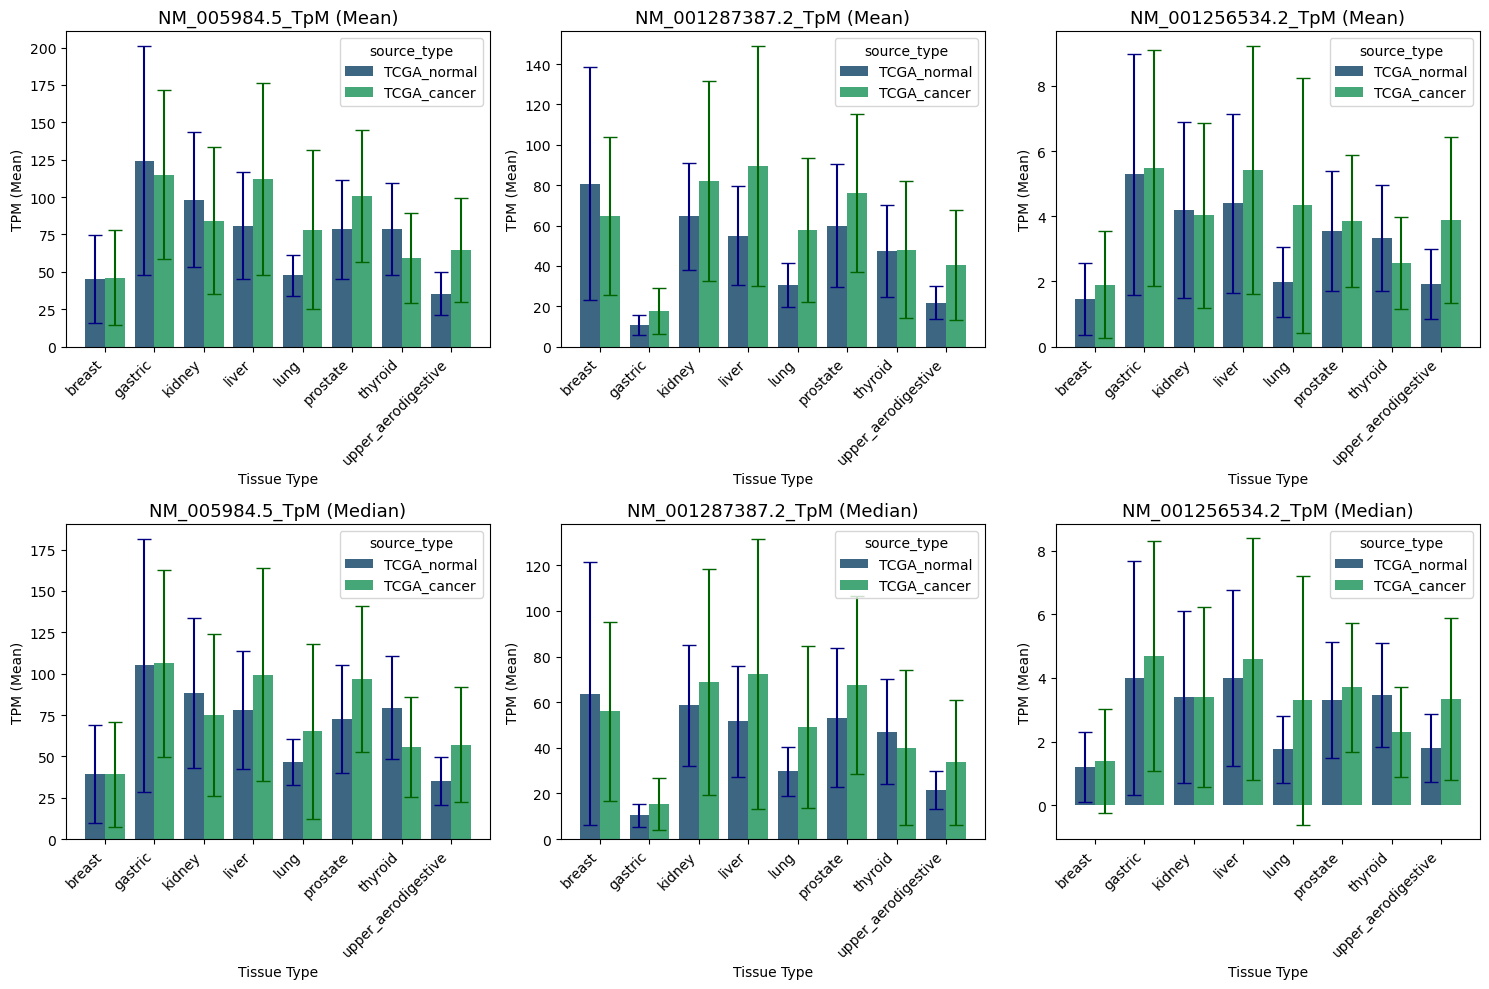

In [24]:
plot_cancer_vs_normal_barplots(melted_df, isoforms, isoform_summary_df, wilcox_df = None, rows = 2, columns = 3, figsize = (15,10), title_size=13)

#### Calculate and Plot Difference Between Cancer and Normal Cells (Delta)

To improve our qualitiative understanding, we want to calculate the delta between the cancer cells and normal cells for each tissue type, across each isoform.  In the next section, we calculate that delta and plot based on highest delta to lowest delta. 

**Note:**
- `delta = cancer_cells - normal_cells` 
    - Positive delta indicates presence of cancer **upregulates** isoform production
    - Negative delta indicates presence of cancer **downregulates** isoform production
- Delta is normalized to a percentage
    - delta is divided by mean isoform expression across all tissue types
        - i.e. A value of 100% means isoform expression doubled in cancer cells relative to the average isoform expression
    - Needed because the main isoform commonly has a TpM of 75 on average, while lowest isoform is < 4.  Hard to compare absolute changes.

In [25]:
# Regroup data to make easy comparison between cancer and normal data for each tissue type
mean_and_med_columns = ['NM_005984.5_TpM_mean', 'NM_005984.5_TpM_median',
                        'NM_001287387.2_TpM_mean', 'NM_001287387.2_TpM_median',
                        'NM_001256534.2_TpM_mean', 'NM_001256534.2_TpM_median']

delta_df = isoform_summary_df.groupby(['tissue_type', 'source_type'])[mean_and_med_columns].mean().unstack()

# Swap levels to put 'TCGA_cancer'/'TCGA_normal' on top
delta_df.columns = delta_df.columns.swaplevel(0, 1)  

# Calculate delta for each category
# +'ve means increased with cancer.  -'ve means decreased with cancer.
delta_df = delta_df['TCGA_cancer'] - delta_df['TCGA_normal']
delta_df = delta_df.add_suffix('_delta')



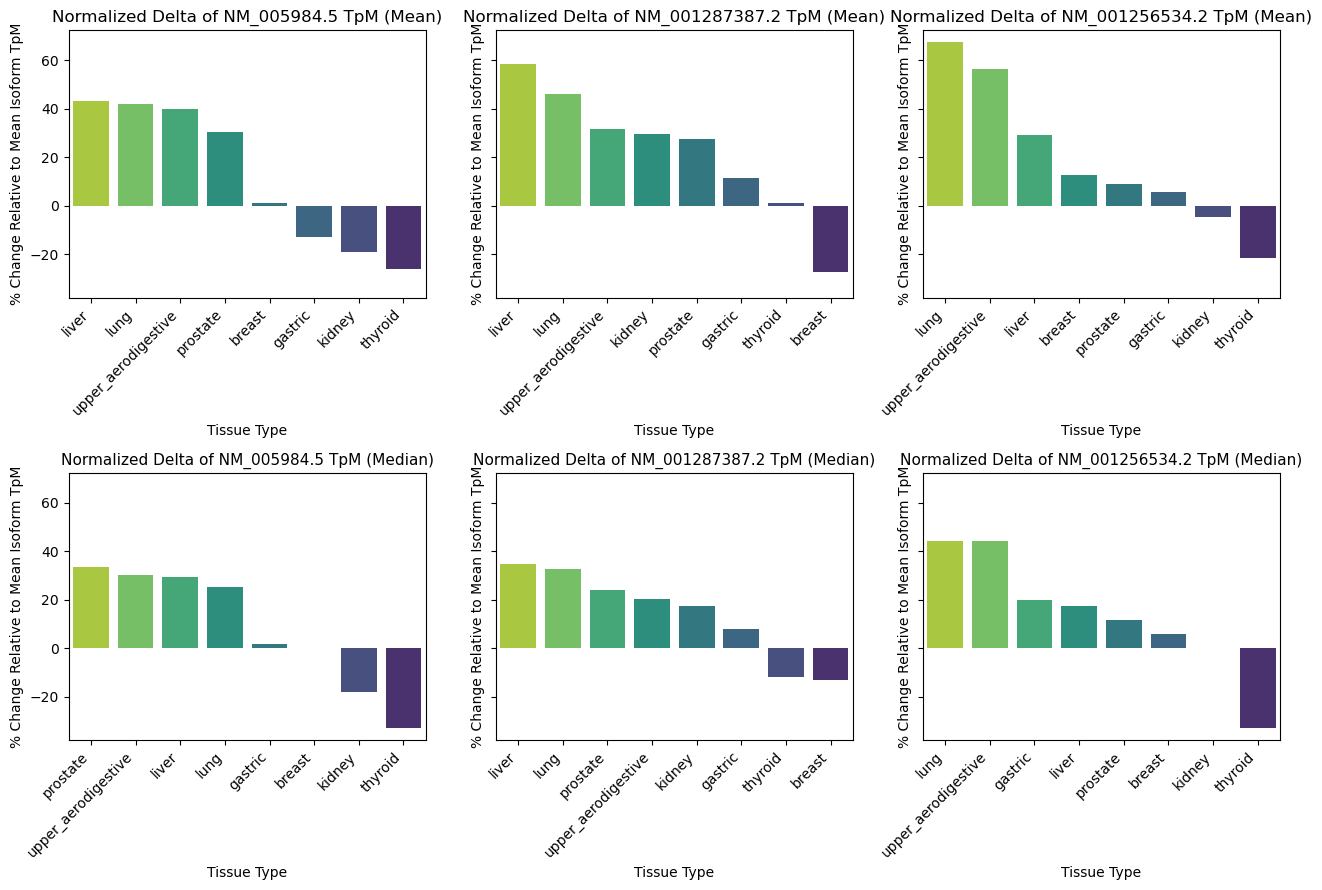

In [26]:
## Plot the results normalized by the average value
fig, axes = plt.subplots(2,3, figsize=(13, 9), sharey=True)

# Define the isoforms to loop through
isoforms = ['NM_005984.5_TpM', 'NM_001287387.2_TpM', 'NM_001256534.2_TpM']

mean_df = df.copy()[isoforms].mean()

for i, isoform in enumerate(isoforms):
    # Isolate the mean and median data, and reorder
    # Normalize the data by mean isoform expression across all tissue types
    mean_data = delta_df[f'{isoform}_mean_delta'].sort_values(ascending=False)/mean_df[isoform]*100
    median_data = delta_df[f'{isoform}_median_delta'].sort_values(ascending=False)/mean_df[isoform]*100
    isoform_num = '_'.join(isoform.split('_')[0:2])
  
    ## Plot the top row (mean data)
    bar_plot = sns.barplot(ax=axes[0,i], x=mean_data.index, y=mean_data.values, palette='viridis_r')

    # Set titles and labels for mean data
    axes[0,i].set_title(f'Normalized Delta of {isoform_num} TpM (Mean)', size=12)
    axes[0,i].set_xlabel('Tissue Type')
    axes[0,i].set_ylabel('% Change Relative to Mean Isoform TpM')
    axes[0,i].tick_params(axis='x', rotation=45)
    for label in axes[0, i].get_xticklabels():
        label.set_ha('right')  # Align the end of the text with the tick position

    ## Plot the bottom row (median data)
    bar_plot = sns.barplot(ax=axes[1,i], x=median_data.index, y=median_data.values, palette='viridis_r')

    # Set titles and labels for median data
    axes[1,i].set_title(f'Normalized Delta of {isoform_num} TpM (Median)', size=11)
    axes[1,i].set_xlabel('Tissue Type')
    axes[1,i].set_ylabel('% Change Relative to Mean Isoform TpM')
    axes[1,i].tick_params(axis='x', rotation=45)
    for label in axes[1, i].get_xticklabels():
        label.set_ha('right')  # Align the end of the text with the tick position

plt.tight_layout()
plt.show()


#### Plot Delta Data by Tissue Type

We want to replot the same data, but separating each figure by tissue type instead of isoform for easier comparison across a given tissue type.

In [27]:
# Melt the delta data to make it easy to plot
melted_delta_df = delta_df.reset_index().melt(id_vars = ['tissue_type'],
                                value_vars = ['NM_005984.5_TpM_mean_delta', 'NM_005984.5_TpM_median_delta',
                                              'NM_001287387.2_TpM_mean_delta', 'NM_001287387.2_TpM_median_delta',
                                              'NM_001256534.2_TpM_mean_delta', 'NM_001256534.2_TpM_median_delta'],
                                              var_name = 'isoform', value_name = 'value')

# Add normalized value based on the mean of entire isoform
melted_delta_df.loc[:,'isoform_clean'] = melted_delta_df['isoform'].str.replace('_mean_delta|_median_delta', '', regex=True)
melted_delta_df.loc[:,'normalized_value'] = melted_delta_df.apply(lambda row: row['value'] / mean_df[row['isoform_clean']]*100, axis=1)

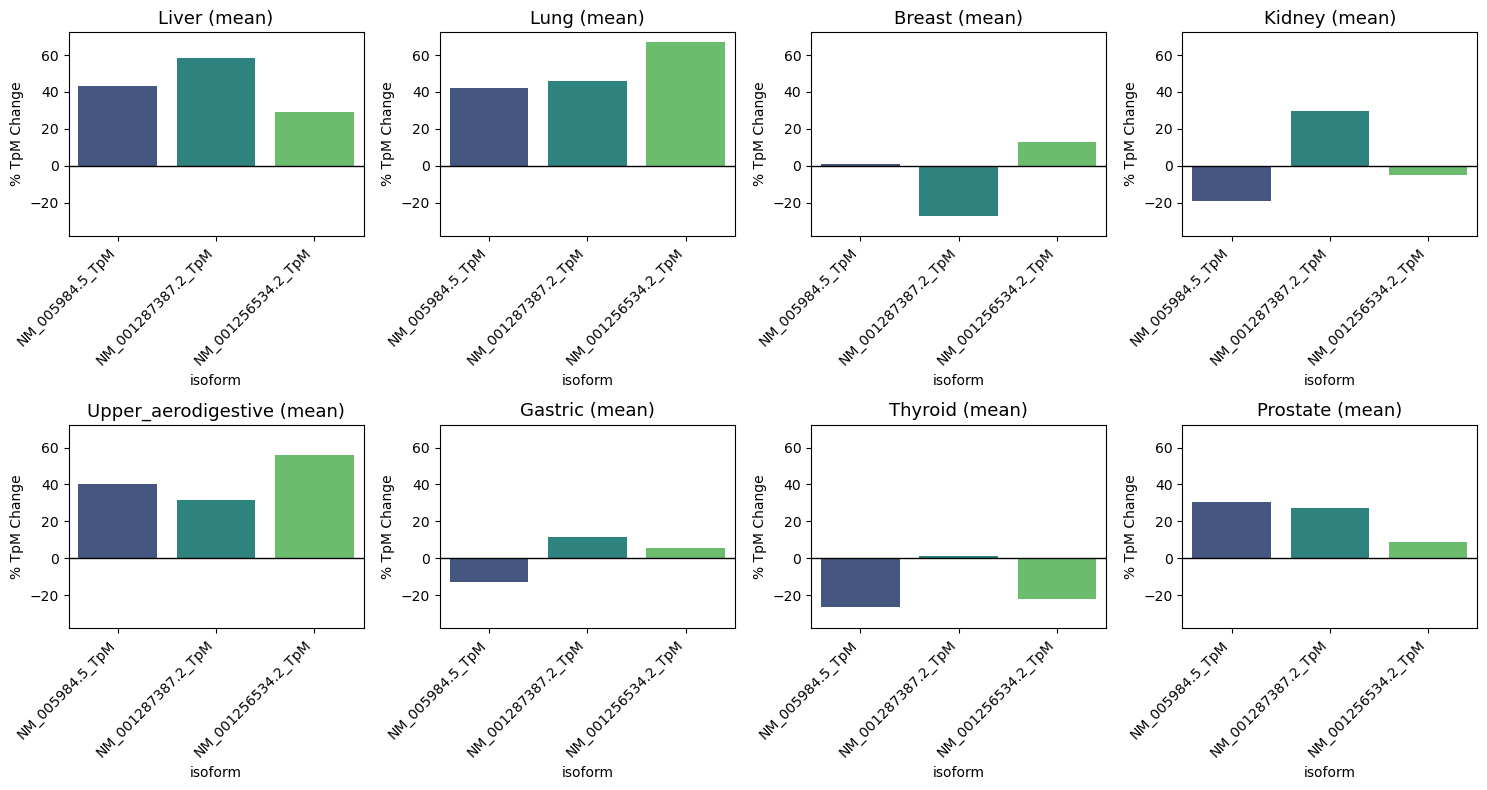

In [28]:
# Select mean or median values for plotting
stat_choice = 'mean'

# Define y-axis limits (optional, if you want consistency across all plots)
y_min = melted_delta_df['normalized_value'].min()-5
y_max = melted_delta_df['normalized_value'].max()+5

# Set up figure with subplots and flatten to make plotting easier
fig, axes = plt.subplots(2,4,figsize=(15,8))
axes= axes.flatten()

# Plot for each tissue type
for i,tissue in enumerate(list(df['tissue_type'].unique())):
    #if i > 3: break
    # Isolate the sample
    sample = melted_delta_df[(melted_delta_df['tissue_type'] == tissue) & ((melted_delta_df['isoform'].str.contains(stat_choice)))]

    # Plot the result
    plot = sns.barplot(ax=axes[i], data=sample, x='isoform_clean', y='normalized_value', palette='viridis')

    # Add a horizontal line at y=0
    axes[i].axhline(y=0, color='black', linewidth=1, linestyle='-')

    # Update plot settings
    axes[i].set_title(f'{tissue.capitalize()} ({stat_choice})', size=13)
    axes[i].set_xlabel('isoform')
    axes[i].set_ylabel('% TpM Change')
    axes[i].tick_params(axis='x', rotation=45)
    for label in axes[i].get_xticklabels():
        label.set_ha('right')  # Align the end of the text with the tick position

    # Set consistent y-axis limits for all plots
    axes[i].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

**Summary:**

- mCiC main isoform and pmCiC isoform (`NM_005984.5` vs `NM_001256534.2`) are commonly correlated
    - exceptions: Gastric

### Tumor vs Control Expression Levels Based on pmCiC Proportion

Taking a step back, we want to repeat the tumor vs control analysis, but using pmCiC proportion instead of TpM.  As noted, the main mCiC isoform and the pmCiC isoform are highly correlated.  Thus, signficiant values in pmCiC TpM difference can be misleading, as mCiC may have increase proportionally.

As a reminder, our hypothesis states that the proportion of the pmCiC isoform increases to provide the cancer cell with more extracellular citrate to support fatty acid production.  Therefore, we want to confirm that there are differences in the pmCiC **proporition** across cancer and control samples.

#### Convert Isoform TpMs to Proportions

We use the following equation to calculate a given isoforms proportion:
- Proportion_T1 = TPM_T1/SUM(TPM_T1 + TPM_T2 + TPM_T3) 
- All proportions for a given sample will sum to 1

In [29]:
# Add Proportion values to the df
isoforms = ['NM_005984.5_TpM', 'NM_001287387.2_TpM', 'NM_001256534.2_TpM'] 

# Calculate proportion as Proportion_T1 = TPM_T1/SUM(TPM_T1 + TPM_T2 + TPM_T3) 
for isoform in isoforms:
    # Get new column name
    name = '_'.join(isoform.split('_')[0:2])

    # Add proportion column to df
    df[f'{name}_proportion'] = df[isoform]/(df[f'{isoforms[0]}'] + df[f'{isoforms[1]}'] + df[f'{isoforms[2]}'])

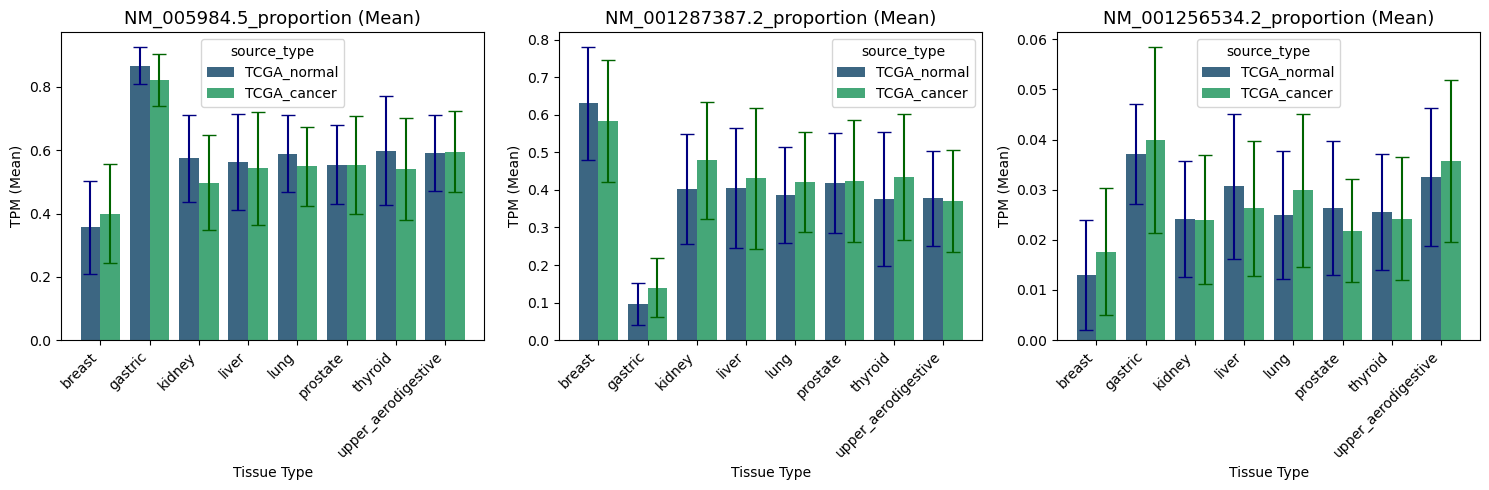

In [30]:
# Plot results based on isoform proportions
isoforms = ['NM_005984.5_proportion', 'NM_001287387.2_proportion', 'NM_001256534.2_proportion'] 
isoform_summary_df, melted_df= prep_and_melt_data(df, isoforms)
plot_cancer_vs_normal_barplots(melted_df, isoforms, isoform_summary_df, wilcox_df=None, plot_median = False, rows = 1, columns = 3, figsize = (15,5), title_size=13)

---

## **3. Statistical Analysis**

We can now look into statistical testing to validate the significance of these potential differences. The goal of this section is to apply methods to determine whether the differences in isoforms expressions between cancerous and non-cancerous samples, are statistically significant in aggregate and across disease types. By doing so, we can draw more concrete conclusions about the role of the citrate transporter isoforms.

### Run Shapiro and Levene Tests to Assess for Normality and Equal Variance

Want to assess for each tissue type if the data distributions are normal and if there are equal variances between the cancer data and the normal data.
- Shapiro test will assess normality
    - signficant p-value means sample is ***not*** normally distributed
- Levene test will assess equal variance assumption
    - significant p-value means variances between distributions are ***not*** equivalent

In [31]:
def run_shapiro_and_levine(df, isoforms):
    '''Runs Shapiro-Wilk normality test on each tissue type and isoform, as well as a Levene 
    test to check equal variance between cancer and normal samples by tissue type'''
    shapiro_df = pd.DataFrame(columns=['tissue_type', 'source_type', 'isoform', 'statistic', 'p_value'])
    levene_df = pd.DataFrame(columns=['tissue_type', 'isoform', 'statistic', 'p_value'])

    # Iterate through each tissue type and isoform
    for tissue in list(df['tissue_type'].unique()):
        for isoform in isoforms:
            ## Perform shapiro test on cancer data
            filtered_data_cancer = df[(df['tissue_type'] == tissue) & (df['source_type'] == 'TCGA_cancer')][isoform]
            stat, p = stats.shapiro(filtered_data_cancer)
            temp_df = pd.DataFrame({'tissue_type': tissue, 'source_type': 'TCGA_cancer', 'isoform': isoform, 'statistic': [stat], 'p_value':[p]})
            shapiro_df = pd.concat([shapiro_df, temp_df], ignore_index=True)

            ## Perform shapiro test on normal data
            try: # Add in try/except clause since some normal data has less than 3 samples
                filtered_data_normal = df[(df['tissue_type'] == tissue) & (df['source_type'] == 'TCGA_normal')][isoform]
                stat, p = stats.shapiro(filtered_data_normal)
                temp_df = pd.DataFrame({'tissue_type': tissue, 'source_type': 'TCGA_normal', 'isoform': isoform, 'statistic': [stat], 'p_value':[p]})
                shapiro_df = pd.concat([shapiro_df, temp_df], ignore_index=True)

                # Run Levene Test to check variance
                stat, p = stats.levene(filtered_data_cancer, filtered_data_normal)
                temp_df = pd.DataFrame({'tissue_type': tissue, 'isoform': isoform, 'statistic': [stat], 'p_value':[p]})
                levene_df = pd.concat([levene_df, temp_df], ignore_index=True)
            except: continue
    return shapiro_df, levene_df

def plot_shapiro_and_levene(shapiro_df, levene_df):
    '''Plot the results from the Shapiro and Levene statistical tests'''
    # Plot the p_value distributions to determine acceptability for t-test
    # Setup figure
    fig, ax = plt.subplots(1,2, figsize=(12,5))

    # Plot the Shapiro p_value distribution
    ax[0].hist(shapiro_df['p_value'].astype(float), bins=20)
    ax[0].set_title('p-values from Shapiro Test (Normality)')
    ax[0].set_xlabel('p-value')
    ax[0].set_ylabel('Frequency')

    # Plot the Levene p_value distribution
    ax[1].hist(levene_df['p_value'].astype(float), bins=20)
    ax[1].set_title('p-values from Levene Test (Equal Variance)')
    ax[1].set_xlabel('p_value')
    ax[1].set_ylabel('Frequency')
    plt.show()

#### Analyze based on TpM Values

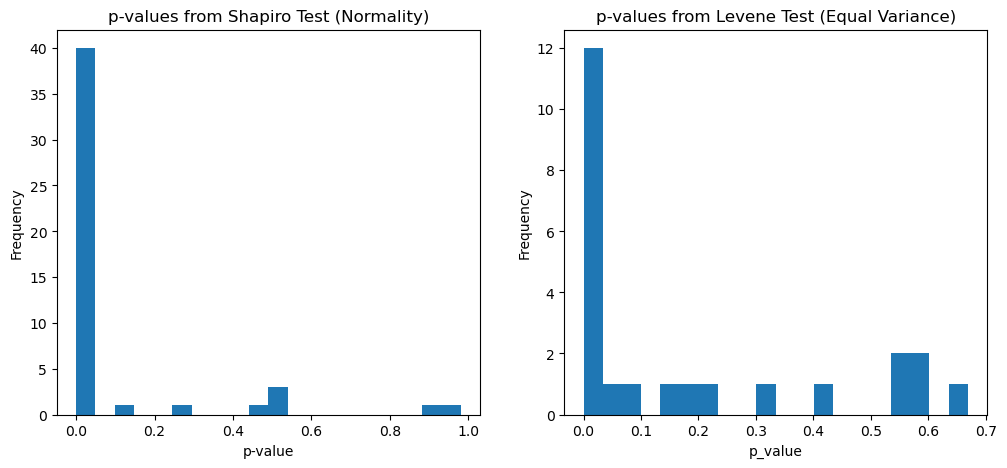

In [32]:
isoforms = ['NM_005984.5_TpM', 'NM_001287387.2_TpM', 'NM_001256534.2_TpM']
shapiro_df, levene_df = run_shapiro_and_levine(df, isoforms)
plot_shapiro_and_levene(shapiro_df, levene_df)

Summary:
- For TpM expression values: 
    - there are many non normally distributed tissue types (p<0.05)
    - there is heteroskedasticity in the variance between cancer and normal samples (p<0.05)


#### Analyze Based on Proportions

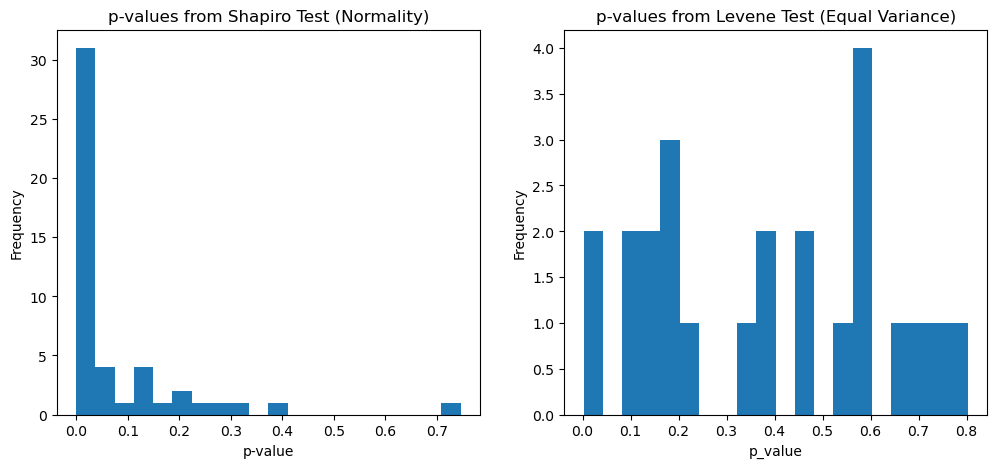

In [33]:
isoforms = ['NM_005984.5_proportion', 'NM_001287387.2_proportion', 'NM_001256534.2_proportion'] 
shapiro_df, levene_df = run_shapiro_and_levine(df, isoforms)
plot_shapiro_and_levene(shapiro_df, levene_df)

Summary:
- For proportion expression values: 
    - there are many non normally distributed tissue types (p<0.05)
    - variance between cancer and control samples is good (flat p value distribution)

##### Decision:

Based on the non-normality of the tissue samples, we select to run a non-parametric **Wilcoxon Rank-Sum test (Mann-Whitney U test)** to statistically identify differences between cancer and normal samples.

### Wilcoxon Rank-Sum Test

We will run the Wilcoxon Rank-Sum test to compare cancer and normal samples across each tissue type.  We will use proportion as the metric of interest.

##### Adjusting p-values
We need to adjust the p-values because we've run multiple tests and need to account for multiple testing.  Otherwise you signficiantly increase your probability of false positive results.  We will run both Bonferonni and Benjamini-Hochberg corrections.

In [80]:
def run_wilcoxon_test(df, isoforms):
    '''Performs wilcoxon rank sum individual isoform TpM's or proportions, for each tissue type,
    comparing distributions of cancer versus normal cells'''
    
    # Set up df to collect results
    wilcox_df = pd.DataFrame(columns=['tissue_type', 'isoform', 'wilcoxen_stat', 'wilcoxen_p_value'])

    # Iterate through each tissue type and isoform
    for tissue in list(df['tissue_type'].unique()):
        for isoform in isoforms:
            ## Identify cancer and normal datasets
            filtered_data_cancer = df[(df['tissue_type'] == tissue) & (df['source_type'] == 'TCGA_cancer')][isoform]
            filtered_data_normal = df[(df['tissue_type'] == tissue) & (df['source_type'] == 'TCGA_normal')][isoform]
            
            # Run wilcoxen rank-sum test
            wilcox_stat, wilcox_p_value = stats.mannwhitneyu(filtered_data_cancer, filtered_data_normal)

            # Append the Wilcoxen test data to the dataframe
            temp_df = pd.DataFrame({'tissue_type': tissue, 'isoform': isoform, 'wilcoxen_stat': [wilcox_stat], 'wilcoxen_p_value':[wilcox_p_value]})
            wilcox_df = pd.concat([wilcox_df, temp_df], ignore_index=True)

    # Adjust the p-values because we've run multiple test and need to account for multiple testing
    # Number of tests
    m = len(wilcox_df)

    ## Apply Bonferroni correction
    wilcox_df['wilcoxen_p_value_adj'] = wilcox_df['wilcoxen_p_value'] * m

    ## Apply Benjamini-Hochberg correction
    wilcox_df = wilcox_df.sort_values(by='wilcoxen_p_value')
    wilcox_df['rank'] = range(1, len(wilcox_df) + 1)

    # Calculate critical values
    alpha = 0.05
    wilcox_df['critical_value'] = (wilcox_df['rank'] / m) * alpha

    # Find largest p-value that is smaller than its critical value
    max_p = wilcox_df[wilcox_df['wilcoxen_p_value'] <= wilcox_df['critical_value']].max()['wilcoxen_p_value']
    wilcox_df['wilcoxen_significant_BH'] = wilcox_df['wilcoxen_p_value'] <= max_p

    return wilcox_df

In [81]:
# Run the Wilcoxon test
isoforms = ['NM_005984.5_proportion', 'NM_001287387.2_proportion', 'NM_001256534.2_proportion'] 
wilcox_df = run_wilcoxon_test(df, isoforms)

In [83]:
display(wilcox_df)

,rank,tissue_type,isoform,wilcoxen_stat,wilcoxen_p_value,wilcoxen_p_value_adj,critical_value,wilcoxen_significant_BH
9,1,kidney,NM_005984.5_proportion,31218.0,2.068608e-08,4.964659e-07,0.002083,True
10,2,kidney,NM_001287387.2_proportion,58906.0,1.030806e-07,2.473933e-06,0.004167,True
8,3,breast,NM_001256534.2_proportion,66657.0,9.907434e-06,2.377784e-04,0.006250,True
15,4,gastric,NM_005984.5_proportion,3004.0,8.682141e-04,2.083714e-02,0.008333,True
5,5,lung,NM_001256534.2_proportion,62405.5,1.260270e-03,3.024648e-02,0.010417,True
16,6,gastric,NM_001287387.2_proportion,6238.0,1.370492e-03,3.289181e-02,0.012500,True
3,7,lung,NM_005984.5_proportion,42878.5,1.779749e-03,4.271398e-02,0.014583,True
18,8,thyroid,NM_005984.5_proportion,11218.0,5.052493e-03,1.212598e-01,0.016667,True
7,9,breast,NM_001287387.2_proportion,44310.0,5.686606e-03,1.364785e-01,0.018750,True
19,10,thyroid,NM_001287387.2_proportion,17677.0,5.724581e-03,1.373899e-01,0.020833,True


#### Plot Proportion of Cancer vs Normal Cells with Statistical Significance

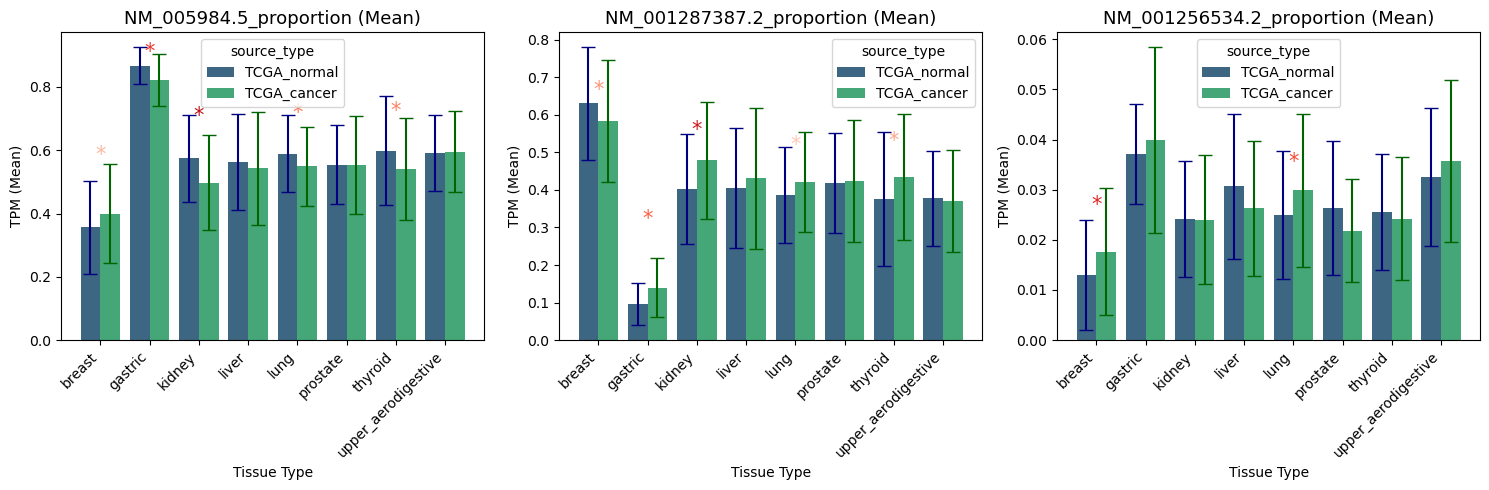

In [37]:
isoforms = ['NM_005984.5_proportion', 'NM_001287387.2_proportion', 'NM_001256534.2_proportion'] 
isoform_summary_df, melted_df= prep_and_melt_data(df, isoforms)
plot_cancer_vs_normal_barplots(melted_df, isoforms, isoform_summary_df, wilcox_df=wilcox_df, plot_median = False, rows = 1, columns = 3, figsize = (15,5), title_size=13)

**Comments:**
- Statistical signficiance is denoted by a red `*` symbol over the corresponding tissue type
    - degree of significant denoted by intensity of red color of `*` symbol.  Darker color is more significant
- Significant determined by Benjamini-Hochberg correction of a Wilcoxen Rank Sum Test

**Summary:**

- for pmCiC (`NM_001256534.2`), only breast and lung are considered signficant
    - Note: These are the two tissue types with the most samples in the database
- There are many statistical differences in the mCiC main isoform (`NM_005984.5`)
    - Most have lower expression in cancer than normal, except for breast tissue
    - Difficult to interpret


---

## **4. Phenotypic Subtype Analysis**

We want to further investigate the Lung and Breast tissue samples due to their statistical signficance of the pmCiC isoform variant proportion. The goal is to add additional phenotypic information to determine if certain subgroups have strong correlation with pmCiC proportion.

### Add Supplemental Information



Here is a summary of the different phenotypic data available to us:

**Curated clinical data**

- DFI - Disease free interval (The patient was disease free at the time the data was collected or not)

- DFI.time - If the patient was not disease free, what was the time between the previous treatment and the latest disease detection

- DSS - Disease specific survival - Patient died from the specific disease (in our case cancer)

- DSS.time - Time to death due to the specific disease 

- OS - Overall survival - Patient dead or alive, reason of the death can be anything

- OS.time - time to death

- PFI - Progression free survival - If the disease has progressed after the last treatment

- PFI.time - Time to progression from the last treatment

- ajcc_pathologic_tumor_stage - A system to describe the amount and spread of cancer in a patient’s body

- cause_of_death 

- clinical_stage - Stage of the cancer

- gender

- histological_grade - Grade of the tutor (High grade is worse)

- tumor_status - Tumor present at the last checkpoint or not



**Immune subtype**

- Subtype_Immune_Model_Based - Clusters of tumours based on immune gene expression



**Molecular subtype - Different clusters based on various features**

- Subtype_CNA 

- Subtype_DNAmeth

- Subtype_Integrative

- Subtype_Selected

- Subtype_mRNA

- Subtype_miRNA

- Subtype_other

- Subtype_protein



**Sample type and primary disease**

- sample_type - Primary (First tumor detected) or Metastatic (Secondary tumor the source of which is tumor somewhere else in the body)

- sample_type_id - ID for sample type

### Load Clinical Subtype Data

In [61]:
patient_supp_info_df = pd.read_csv(PATIENT_SUPP_INFO_FILE_PATH, sep = '\t')

In [62]:
# Change filename format from original dataframe to match supplementary dataframes

def long_filename_to_short_filename(long_file_name_string):
    '''Converts the long filename format in the TCGA gene sample to the
    short filename format from the supplementary info'''

    # Split the string and isolate the first few components
    split_string = long_file_name_string.split('-')
    front_part = split_string[0:3]

    # Separate the numbers and letters of the last component
    last_part = split_string[3][0:2] # Take the numbers out of the NNL where N=num and L=letter combination
 
    # Append and recombine string
    front_part.append(last_part)
    short_filename = '-'.join(front_part)
    return short_filename

# Add short filename to main df to allow merging
df['sample'] = df['FileName'].apply(lambda x: long_filename_to_short_filename(x))

In [63]:
# Isolate sample ids from supplementary data
patient_supp_info_sample_ids = patient_supp_info_df['sample']

# Isolate sample ids from initial tissue data
tissue_sample_ids = df['sample']

# Determine the overlap of ids
overlap_ids = np.intersect1d(patient_supp_info_sample_ids, tissue_sample_ids)

print(f'There are {len(patient_supp_info_df)} samples in the patient supplementary database')
print(f'There are {len(tissue_sample_ids)} samples in the original database')
print(f'There are {len(overlap_ids)} samples that overlap between the databases')

There are 12591 samples in the patient supplementary database
There are 4824 samples in the original database
There are 4821 samples that overlap between the databases


### Load Immune Subtype Data

In [64]:
immune_supp_info_df = pd.read_csv(IMMUNE_FILE_PATH, sep = '\t')

In [65]:
# Isolate sample ids from supplementary data
immune_supp_info_sample_ids = immune_supp_info_df['sample']

# Determine the overlap of ids
overlap_ids = np.intersect1d(immune_supp_info_sample_ids, tissue_sample_ids)

print(f'There are {len(immune_supp_info_sample_ids)} samples in the immune supplementary database')
print(f'There are {len(tissue_sample_ids)} samples in the original database')
print(f'There are {len(overlap_ids)} samples that overlap between the databases')

There are 9126 samples in the immune supplementary database
There are 4824 samples in the original database
There are 4037 samples that overlap between the databases


### Load Molecular Subtype Data

In [66]:
# Pull in data
molecular_supp_info_df = pd.read_csv(MOLECULAR_FILE_PATH, sep = '\t')

# Rename the sample column to be consistent with other dataframes
columns = list(molecular_supp_info_df.columns)
columns[0] = 'sample'
molecular_supp_info_df.columns = columns

In [67]:
# Isolate sample ids from supplementary data
molecular_supp_info_sample_ids = molecular_supp_info_df['sample']

# Determine the overlap of ids
overlap_ids = np.intersect1d(molecular_supp_info_sample_ids, tissue_sample_ids)

print(f'There are {len(molecular_supp_info_sample_ids)} samples in the immune supplementary database')
print(f'There are {len(tissue_sample_ids)} samples in the original database')
print(f'There are {len(overlap_ids)} samples that overlap between the databases')

There are 7734 samples in the immune supplementary database
There are 4824 samples in the original database
There are 3505 samples that overlap between the databases


### Load Sample Type Data

In [68]:
# Pull in data
sample_type_supp_info_df = pd.read_csv(SAMPLE_TYPE_FILE_PATH, sep = '\t')

### Load Purity Data

In [69]:
# Load in the dataframe
purity_supp_info_df = pd.read_csv(PURITY_FILE_PATH)

# Reset the index name to be "sample" and drop all columns except sample and purity
purity_supp_info_df.rename(columns={"Unnamed: 0": "sample"}, inplace=True)
purity_supp_info_df = purity_supp_info_df[['sample', 'Purity']]

### Merge Dataframes

In [71]:
# Merge with the patient data
merged_df = pd.merge(df, patient_supp_info_df, how='left', on='sample')

# Merge with the immune subtype data
merged_df = pd.merge(merged_df, immune_supp_info_df, how='left', on='sample')

# Merge with the molecular subtype data
merged_df = pd.merge(merged_df, molecular_supp_info_df, how='left', on='sample')

# Merge with the sample type subtype data
merged_df = pd.merge(merged_df, sample_type_supp_info_df, how='left', on='sample')

# Merge with the purity data
merged_df = pd.merge(merged_df, purity_supp_info_df, how='left', on='sample')

merged_df.head(2)

,FileName,NM_001256534.2_Read_Counts,NM_001256534.2_TpM,NM_001287387.2_Read_Counts,NM_001287387.2_TpM,NM_005984.5_Read_Counts,NM_005984.5_TpM,ENSG00000100075,tcga_merge_name,tissue_type,disease_type,source_type,NM_005984.5_proportion,NM_001287387.2_proportion,NM_001256534.2_proportion,sample,_PATIENT,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,menopause_status,birth_days_to,vital_status,tumor_status,last_contact_days_to,death_days_to,cause_of_death,new_tumor_event_type,new_tumor_event_site,new_tumor_event_site_other,new_tumor_event_dx_days_to,treatment_outcome_first_course,margin_status,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,Subtype_Immune_Model_Based,Subtype_mRNA,Subtype_DNAmeth,Subtype_protein,Subtype_miRNA,Subtype_CNA,Subtype_Integrative,Subtype_other,Subtype_Selected,sample_type_id,sample_type,_primary_disease,Purity
0,TCGA-FV-A3I0-11A-11R-A22L-07_c8a84054-d6cd-45b...,316.2415,7.4,1426.2735,36.7,5038.4850,126.2,136.5,TCGA-FV-A3I0-11,liver,LIHC,TCGA_normal,0.741045,0.215502,0.043453,TCGA-FV-A3I0-11,TCGA-FV-A3I0,LIHC,76.0,FEMALE,WHITE,Stage II,NaN,Hepatocholangiocarcinoma (Mixed),G2,2011.0,NaN,-28101.0,Alive,WITH TUMOR,848.0,NaN,NaN,Intrahepatic Recurrence,Liver,NaN,159.0,NaN,NaN,R0,0.0,848.0,0.0,848.0,1.0,159.0,1.0,159.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,Solid Tissue Normal,liver hepatocellular carcinoma,NaN
1,TCGA-62-8394-01A-11R-2326-07_11d49add-1b81-436...,428.0903,14.1,2671.5974,96.7,7397.2906,260.8,304.5,TCGA-62-8394-01,lung,LUAD,TCGA_cancer,0.701830,0.260226,0.037944,TCGA-62-8394-01,TCGA-62-8394,LUAD,65.0,FEMALE,WHITE,Stage IIIB,NaN,Lung Adenocarcinoma,NaN,2008.0,NaN,-23758.0,Dead,TUMOR FREE,NaN,139.0,NaN,NaN,NaN,NaN,NaN,Complete Remission/Response,NaN,NaN,1.0,139.0,0.0,139.0,0.0,139.0,0.0,139.0,NaN,IFN-gamma Dominant (Immune C2),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Primary Tumor,lung adenocarcinoma,0.471394


#### Isolate the tissue and adjust columns

In [73]:
# Isolate the tissue type
def isolate_tissue_and_adjust_df(merged_df, tissue_type):
    '''Takes in a full merged_df that contains information for all tissue types and returns
    a tissue specific dataframe and a tissue specific cancer only dataframe'''

    tissue_df = merged_df[merged_df['tissue_type'] == tissue_type]
    tissue_cancer_only_df = tissue_df[tissue_df['source_type'] == 'TCGA_cancer']

    tissue_df = adjust_columns(tissue_df)
    tissue_cancer_only_df = adjust_columns(tissue_cancer_only_df)

    return tissue_df, tissue_cancer_only_df

def adjust_columns(df):
    # Make a copy of the dataframe to avoid SettingWithCopyWarning
    df = df.copy()

    ## Assign stage order
    stage_order = ['Stage I', 'Stage IA', 'Stage IB', 'Stage II', 'Stage IIA', 'Stage IIB', 
                'Stage III', 'Stage IIIA', 'Stage IIIB', 'Stage IV', '[Discrepancy]', 'nan']

    # Convert the 'ajcc_pathologic_tumor_stage' column to a categorical type with the specified order
    df.loc[:,'ajcc_pathologic_tumor_stage'] = pd.Categorical(df['ajcc_pathologic_tumor_stage'], 
                                                            categories=stage_order, 
                                                            ordered=True)  
    
    ## Adjust age
    # Bucket age into groups
    bins = [40, 50, 60, 70, 80, 90]  
    labels = ['40-50', '50-60', '60-70', '70-80', '80-90']

    # Define a mapping for the race names you want to shorten
    race_mapping = {
        "BLACK OR AFRICAN AMERICAN": "BLACK",
        "AMERICAN INDIAN OR ALASKA NATIVE": "AMERICAN INDIAN", 
        "[Not Evaluated]": "[Unknown]"}

    # Apply the mapping to the race column
    df['race'] = df['race'].replace(race_mapping)

    # Define a mapping for the immune types to shorten
    immune_mapping = {
        "Wound Healing (Immune C1)": "C1",
        "IFN-gamma Dominant (Immune C2)": "C2",
        "Inflammatory (Immune C3)": "C3",
        "Lymphocyte Depleted (Immune C4)": "C4",
        "Immunologically Quiet (Immune C5)": "C5",
        "TGF-beta Dominant (Immune C6)": "C6"
        }

    # Apply the mapping to the race column
    df['Subtype_Immune_Model_Based'] = df['Subtype_Immune_Model_Based'].replace(immune_mapping)

    # Create a new column with binned age groups
    df.loc[:,'age_binned'] = pd.cut(df['age_at_initial_pathologic_diagnosis'], bins=bins, labels=labels, right=False)

    ## Adjust DSS, DFI, OS, PFI
    bins = [0, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 11000]  # Replace 'DSS_column' with the actual column name for DSS
    labels = ['0-500', '500-1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000', '5000-6000', '6000-7000', '7000+']

    # Create new binned columns for each subtype
    # EDA revelated all subtypes are on approximately the same scale
    df.loc[:,'DFI_binned'] = pd.cut(df['DFI.time'], bins=bins, labels=labels, right=False)
    df.loc[:,'DSS_binned'] = pd.cut(df['DSS.time'], bins=bins, labels=labels, right=False)
    df.loc[:,'OS_binned'] = pd.cut(df['OS.time'], bins=bins, labels=labels, right=False)
    df.loc[:,'PFI_binned'] = pd.cut(df['PFI.time'], bins=bins, labels=labels, right=False)

    # Convert pmCiC proportion to a tissue specific low, medium, or high
    # Calculate quantiles
    low_threshold = df['NM_001256534.2_proportion'].quantile(0.33)
    high_threshold = df['NM_001256534.2_proportion'].quantile(0.67)

    # Define categories based on thresholds
    def categorize(value):
        if value <= low_threshold:
            return 'Low'
        elif value <= high_threshold:
            return 'Medium'
        else:
            return 'High'

    # Apply categorization to create a new column
    df['tissue_specific_pmCiC_category'] = df['NM_001256534.2_proportion'].apply(categorize)

    ## Cancer Stage
    # Define a mapping for each stage variant to a simplified stage label
    stage_mapping = {
        'Stage I': 'Stage I', 'Stage IA': 'Stage I', 'Stage IB': 'Stage I',
        'Stage II': 'Stage II', 'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II',
        'Stage III': 'Stage III', 'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III',
        'Stage IV': 'Stage IV', '[Discrepancy]': np.nan, 'nan': np.nan
    }

    # Apply the mapping to create a new column with the updated stages
    df['binned_stage'] = df['ajcc_pathologic_tumor_stage'].replace(stage_mapping)

    # Define the ordered categories
    stage_order = ["Stage I", "Stage II", "Stage III", "Stage IV"]

    # Convert the column to a categorical type with the specified order
    df['binned_stage'] = pd.Categorical(df['binned_stage'], categories=stage_order, ordered=True)

    ## DSS Timing
    # Define a function to convert days to years and categorize into buckets
    def categorize_dss_years(days):
        years = days / 365  # Convert days to years
        if years <= 3:
            return '0-3 years'
        elif 4 <= years <= 7:
            return '4-7 years'
        else:
            return '8+ years'

    # Apply the function to create a new column with year buckets
    df['DSS_years_bucket'] = df['DSS.time'].apply(categorize_dss_years)

     # Define the ordered categories
    stage_order = ["0-3 years", "4-7 years", "8+ years"]

    # Convert the column to a categorical type with the specified order
    df['DSS_years_bucket'] = pd.Categorical(df['DSS_years_bucket'], categories=stage_order, ordered=True)

    return df


#### Set up function for plotting

In [74]:
def plot_subtype_analysis(subset_df, tissue_type, subtypes, row_fig_size = 5, row_col_size = 5, 
                          outcome_variable = 'NM_001256534.2_proportion', subtype_category=''):
    '''Takes a dataframe for a given tissue type and plots boxplot analysis on each
    subtype to visualize subtype differences in proportion'''
    

    # Identify which molecular subtypes have do not have data
    # Only save the ones that will be useful for plotting
    subtypes_trimmed = []
    for subtype in subtypes:
        all_nan = subset_df[subtype].isna().all()
        if all_nan: continue
        else: subtypes_trimmed.append(subtype)

    # Plot results
    # Determine the optimal grid size (rows and columns)
    num_plots = len(subtypes_trimmed)
    cols = int(np.ceil(np.sqrt(num_plots)))  # Optimal number of columns
    rows = int(np.ceil(num_plots / cols))    # Optimal number of rows

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(row_col_size * cols, row_fig_size * rows))

    # Figure title
    fig.suptitle(f'{tissue_type.capitalize()}: {subtype_category} ({outcome_variable})', fontsize=15, fontweight='bold')

    # Convert axes to at least 2D, even if rows=1 or columns=1
    axes = np.atleast_2d(axes)

    # Flatten the axes array in case of multi-row and multi-column grids
    axes = axes.flatten()

    # Add the plots to the figure
    for i, subtype in enumerate(subtypes_trimmed):
        sns.boxplot(ax=axes[i], data=subset_df, x=subtype, y=outcome_variable,
                        palette='viridis')
        
        # Get the tick labels (which are sorted in the correct order by Seaborn)
        x_labels = [tick.get_text() for tick in axes[i].get_xticklabels()]

        # Loop through the labels and assign the correct n value
        for j, label in enumerate(x_labels):
            # Filter out categories with n=0 and calculate the n value for each label
            if label and label != 'nan':  # Ignore NaN labels
                n = subset_df[subset_df[subtype] == label].shape[0]
                if n > 0:  # Only display for n > 0
                    # Add the annotation at the top of the chart (right below the top line of the plot)
                    y_max = axes[i].get_ylim()[1]  # Get the top of the y-axis
                    axes[i].text(j, y_max - 0.08 * y_max, f'n={n}', ha='center', fontsize=8, color='black')
                    
        
        # Adjust labels and x axis 
        axes[i].set_title(f'{tissue_type.capitalize()} pmCIC Proportion by {subtype}')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)

    for j in range(i+1, rows*cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


#### Setup Clinical Subtypes

In [75]:
# Definte subtype categories
clinical_subtypes = ['ajcc_pathologic_tumor_stage', 'age_binned', 'gender', 'race', 'histological_grade', 'tumor_status', 'clinical_stage',
            'DFI', 'DFI_binned', 'DSS', 'DSS_binned', 'OS', 'OS_binned', 'PFI', 'PFI_binned', 'binned_stage', 'DSS_years_bucket']

immune_subtypes = ['Subtype_Immune_Model_Based']

molecular_subtypes = ['Subtype_mRNA', 'Subtype_DNAmeth', 'Subtype_protein', 'Subtype_miRNA', 'Subtype_CNA', 
                        'Subtype_Integrative', 'Subtype_other', 'Subtype_Selected']

sample_subtypes = ['sample_type', 'sample_type_id']

# Summarize names and subtype lists
subtype_list = [clinical_subtypes, immune_subtypes, molecular_subtypes, sample_subtypes]
subtype_categories = ['Clinical Subtypes', 'Immune Subtypes', 'Molecular Subtypes', 'Sample Subtypes']


### Investigate Lung Tissue Subtypes

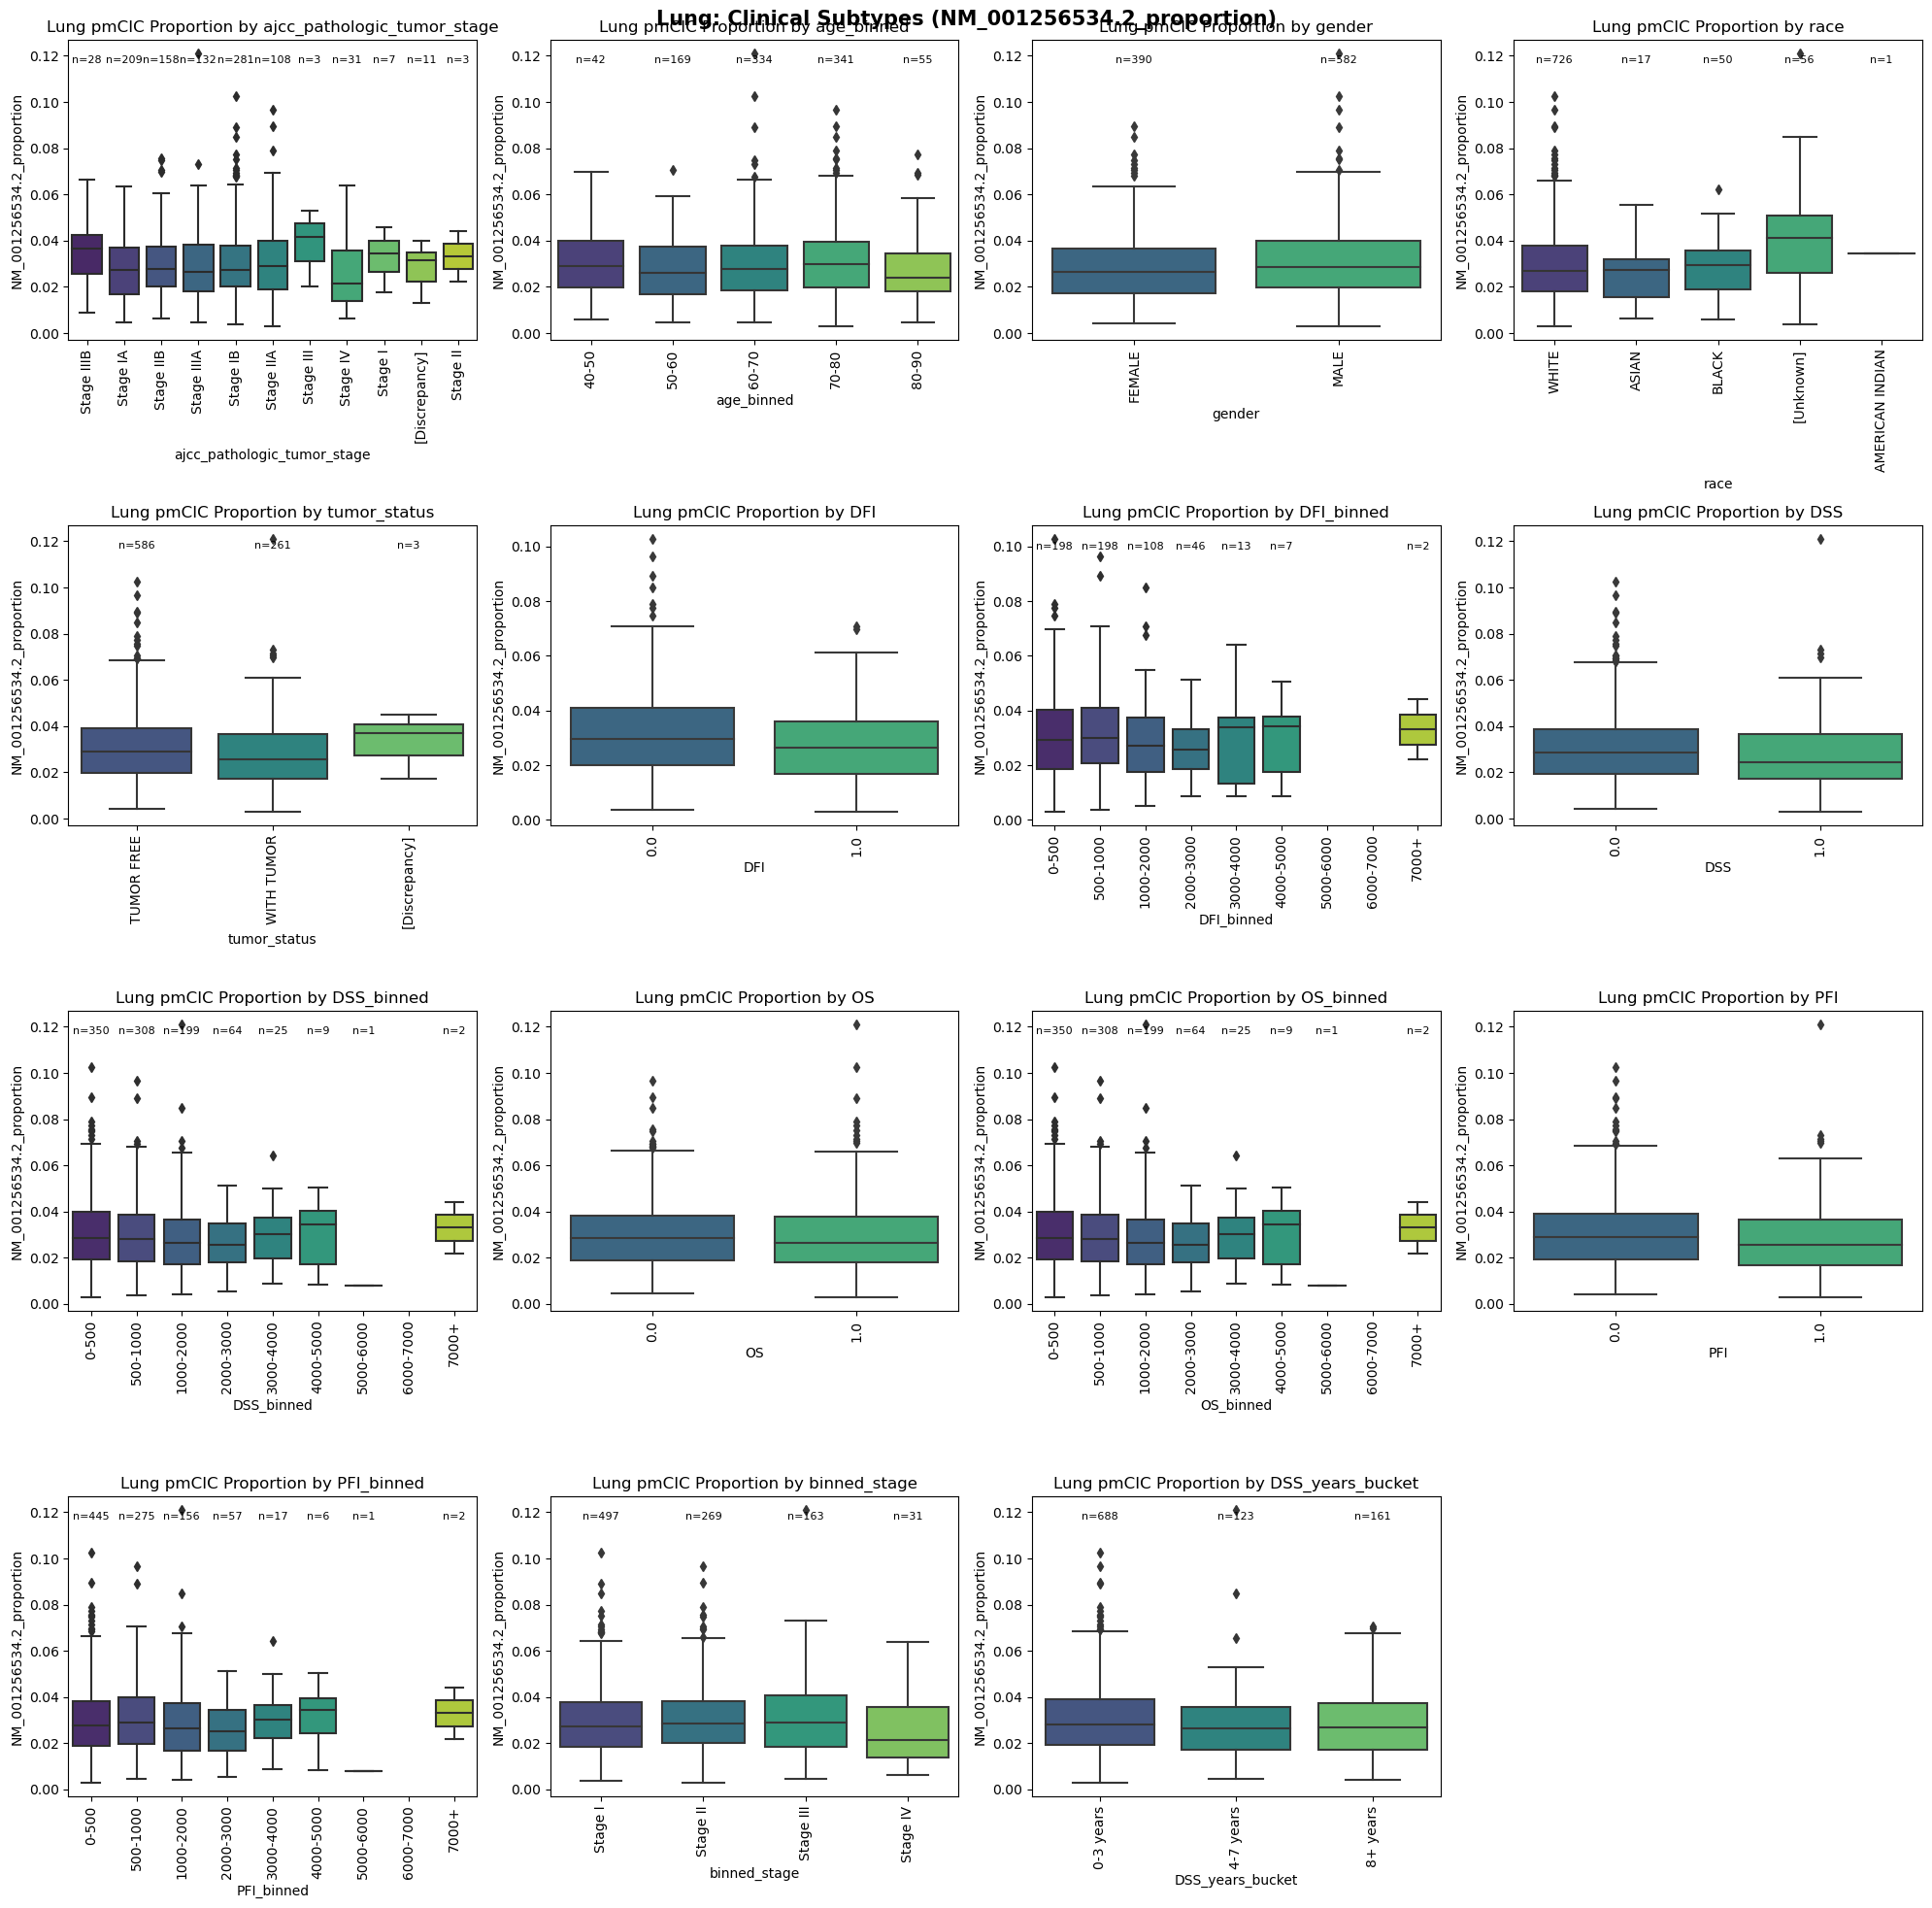

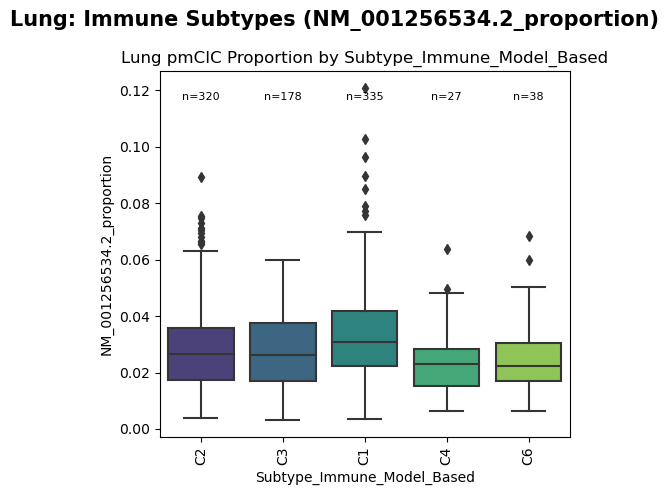

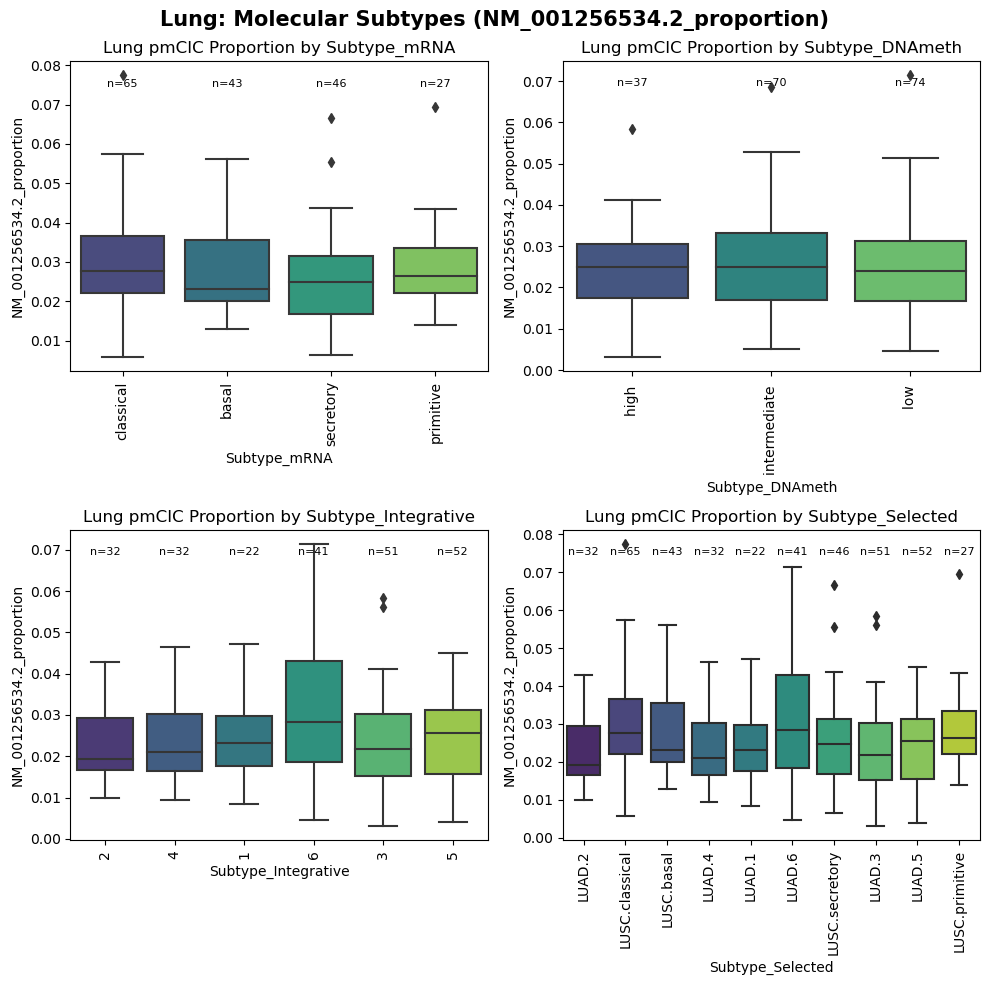

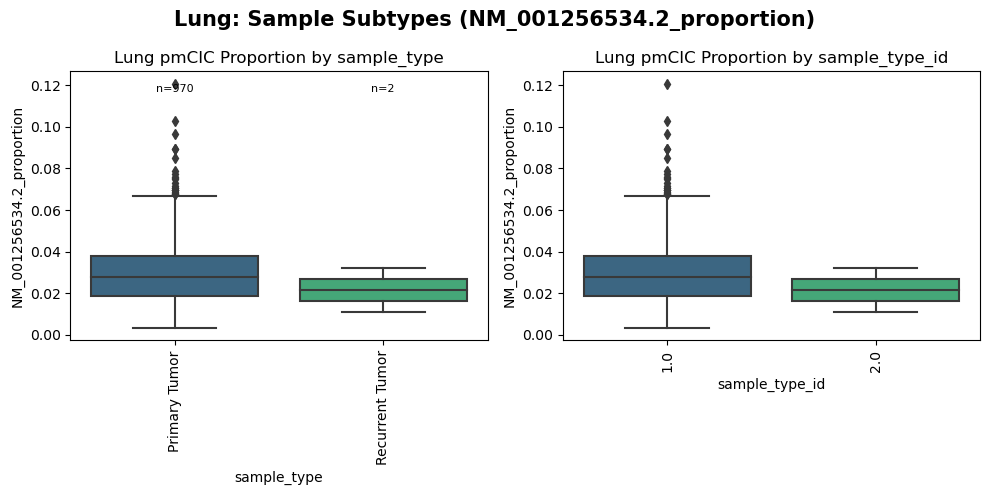

In [76]:
# Isolate appropriate tissue samples
tissue_type = 'lung'
tissue_df, tissue_cancer_only_df = isolate_tissue_and_adjust_df(merged_df, tissue_type)

# Plot results
for i in range(len(subtype_list)):
    plot_subtype_analysis(tissue_cancer_only_df, tissue_type, subtype_list[i], subtype_category=subtype_categories[i])

**Summary of Lung Tissue Subtypes**

moderate change in :
- immune subtype
- subtype_integrative & subtype_selected (molecular)
- subtype_mRNA

small change in:
- gender
- DFI
- PFI binned
- sample type (too low sample size)

###  Investigate Breast Tissue Subtypes

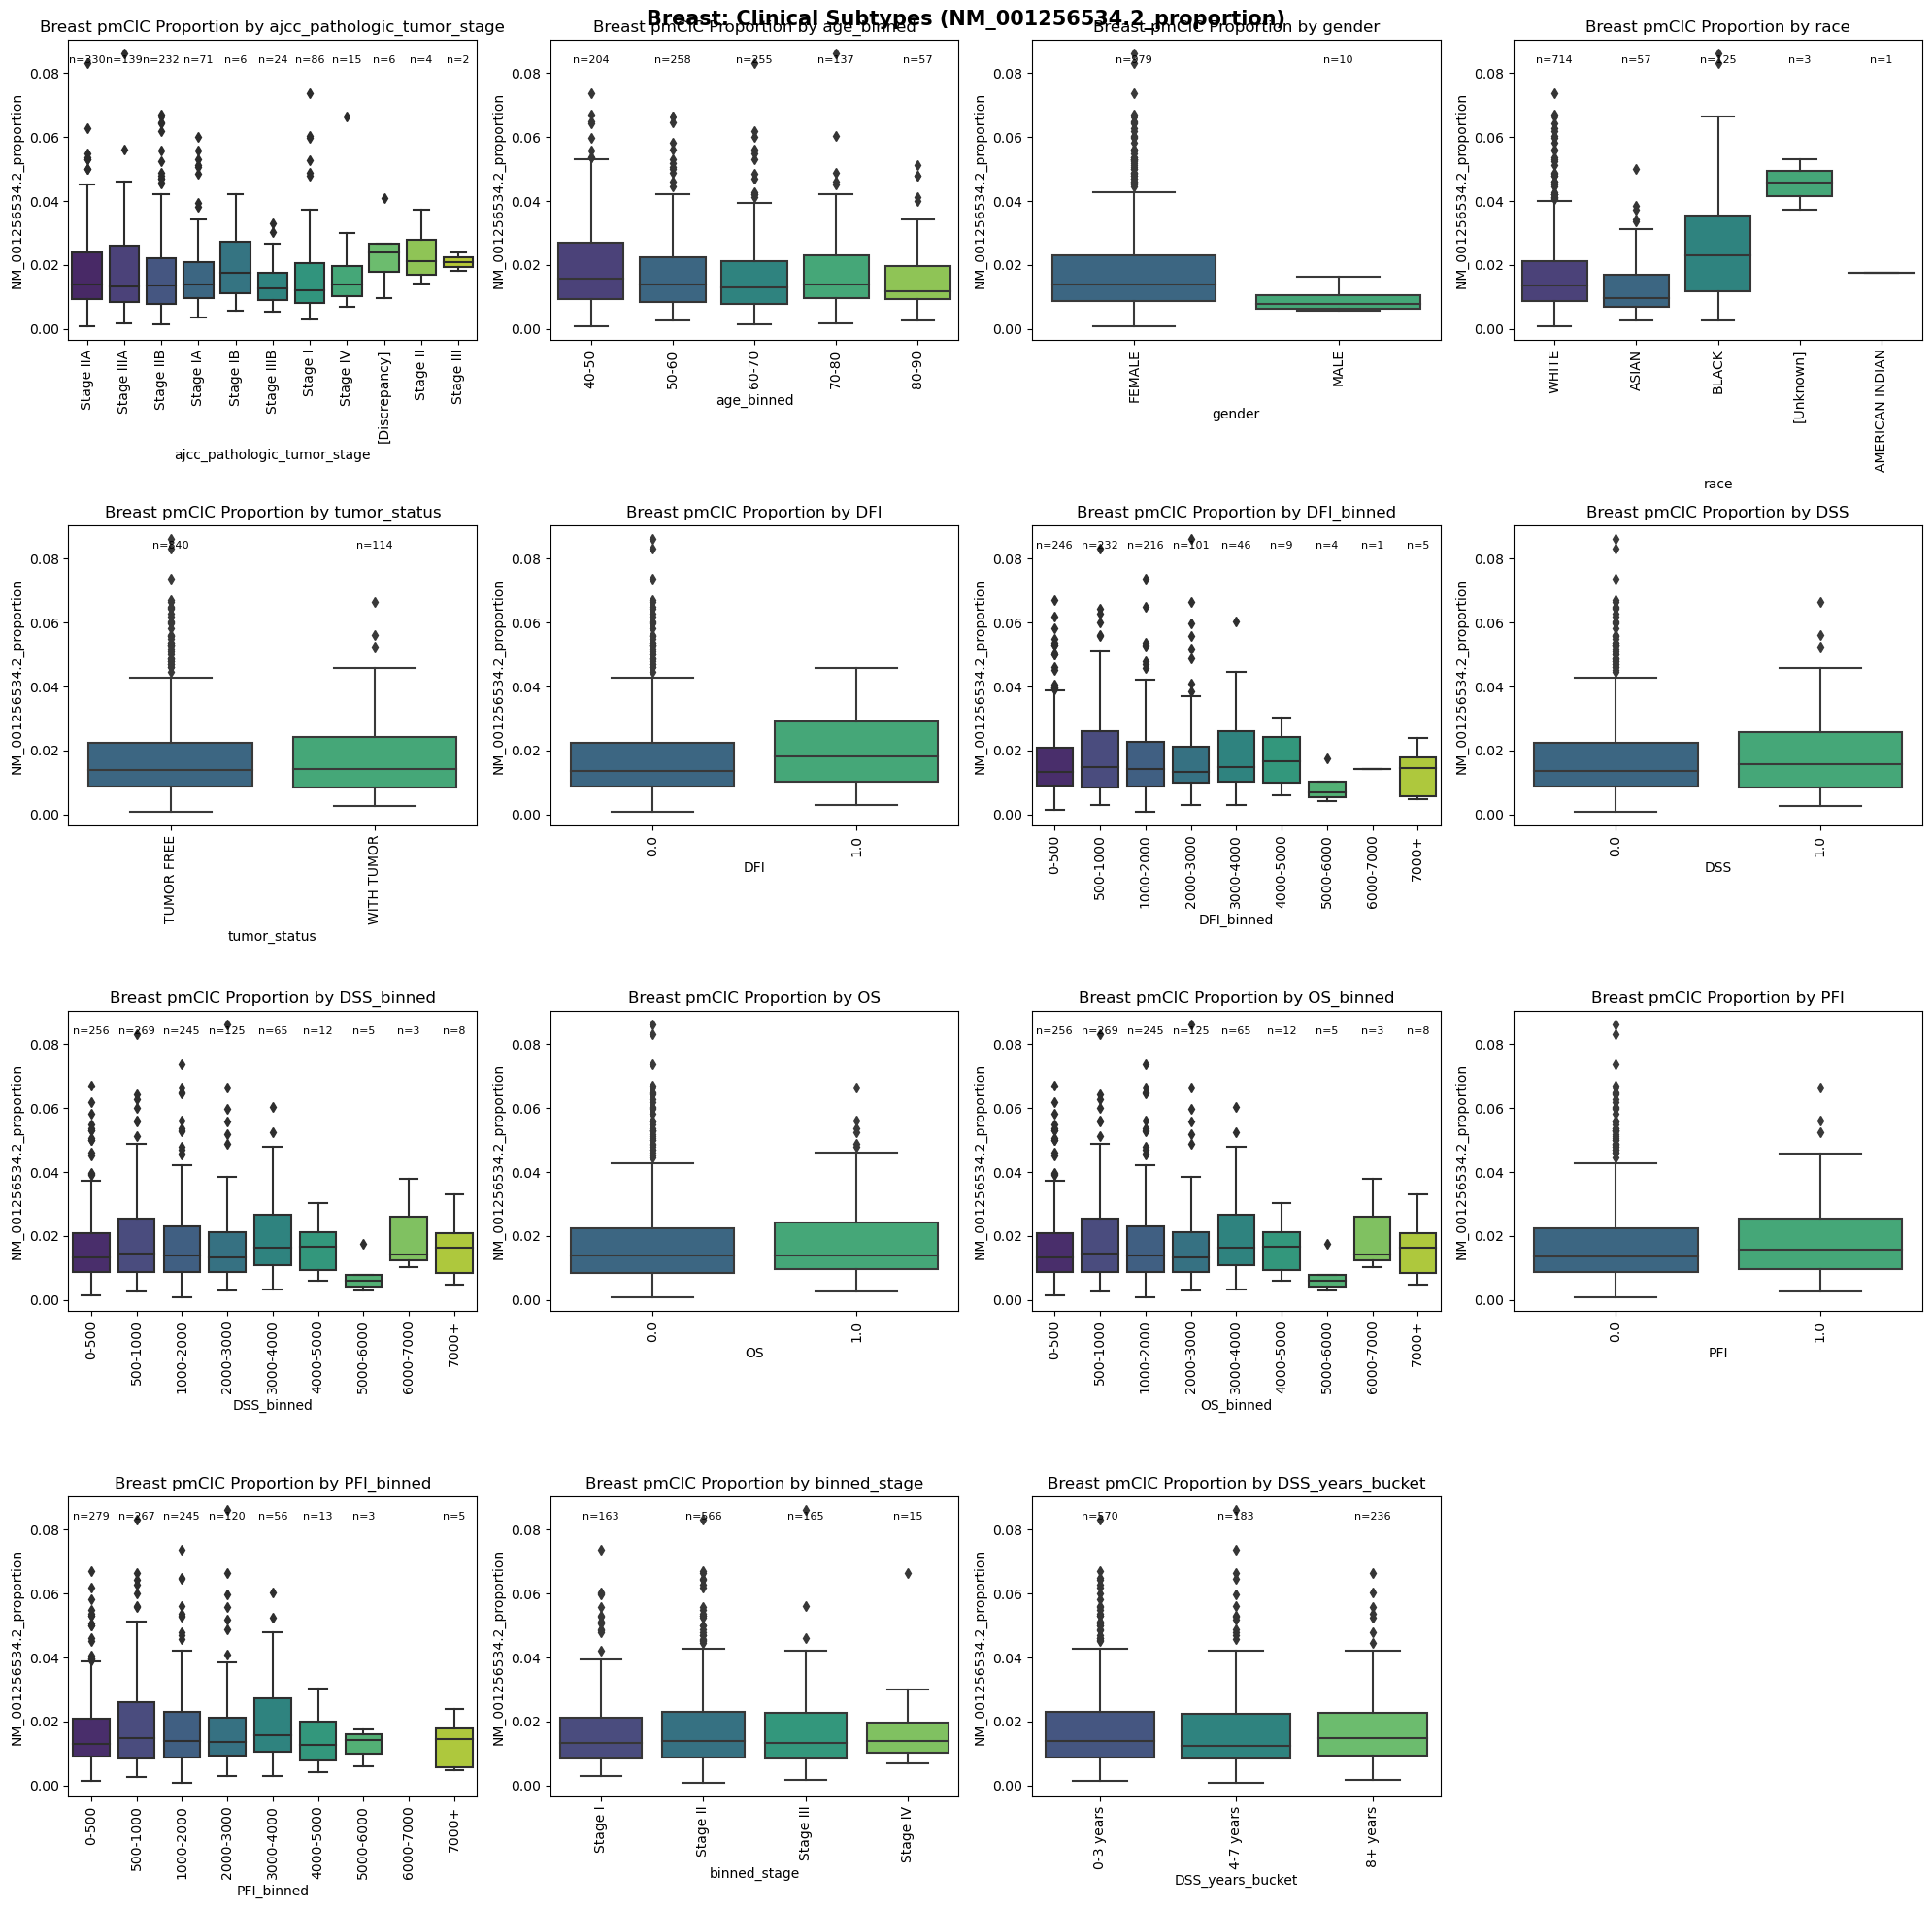

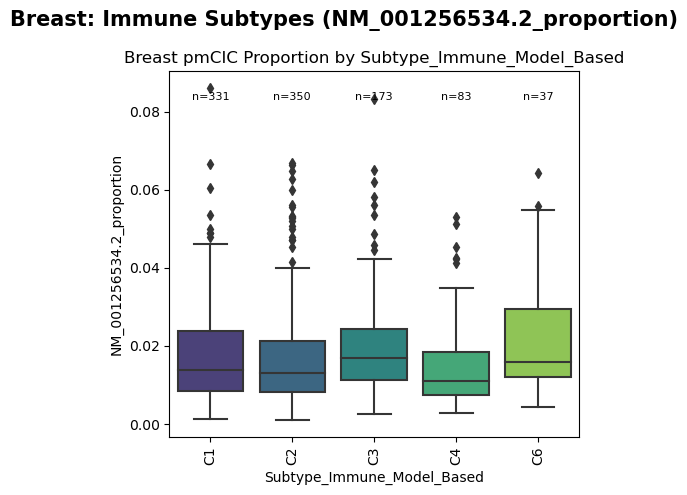

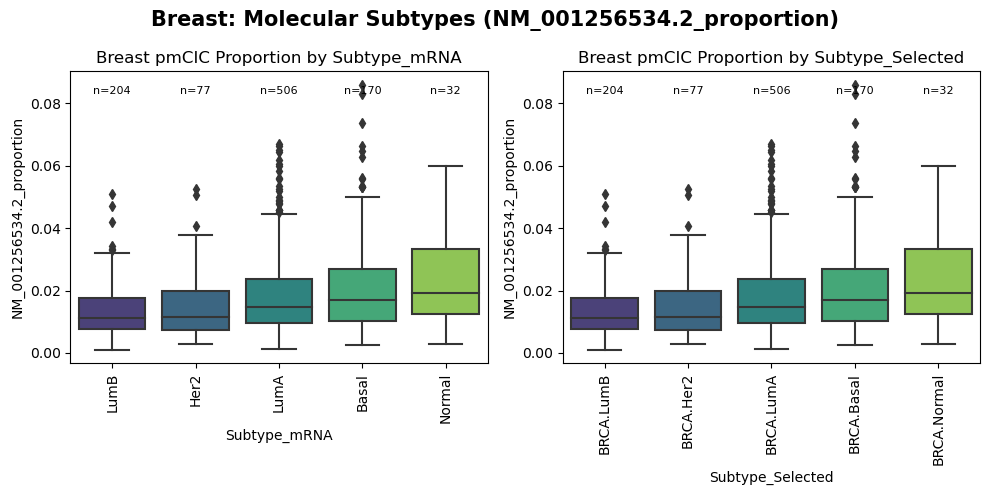

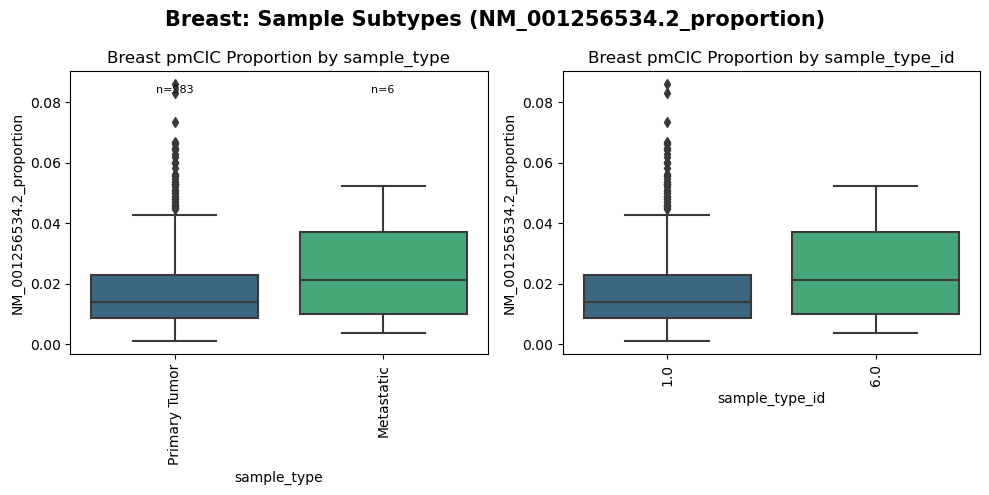

In [ ]:
# Isolate appropriate tissue samples
tissue_type = 'breast'
tissue_df, tissue_cancer_only_df = isolate_tissue_and_adjust_df(merged_df, tissue_type)

# Plot results
for i in range(len(subtype_list)):
    plot_subtype_analysis(tissue_cancer_only_df, tissue_type, subtype_list[i], subtype_category=subtype_categories[i])

**Summary of Breast Tissue Subtypes**

moderate change in :
- race
- gender (low count for men)
- subtype_mRNA & subtype selected (molecular)

small changes in:
- DFI
- PFI binned
- immune subtype

---

## **5. Revisit Statistical Analysis (Phenotypic Data)**

Based on our hypothesis, we suspect that tumor grade and survival times would be impacted by pmCiC proportion.  Specifically, the more pmCiC, the more aggresive the tumor, thus the shorter the survival time and the more advanced tumor stage.  Let's see what we observe quantitatively.

Additionally, we want to investigate subtypes where we observed a likely trend (immune and mRNA)

Therefore, we have 4 subtypes of interest:
- **Tumor Stage**
- **Binned DSS (Disease Specific Survival)**
- **Immune subtype**
- **mRNA subtype**


**Statistical Experimental Design:**

- We will run a Kruskal-Wallis test for each subtype (4 subtypes) for each tissue (breast and lung)
    - This is 8 total tests.  
- We will perform a Benjamini-Hochberg correction across all tests
- For signficaint tests, we will follow up with a subtype specific Dunn's test to make pairwise comparisons
    - A Benjamini-Hochberg correction will be applied within each Dunn test

#### Peform Kruskal-Wallis Tests Against Subtypes

In [78]:
# Select subtypes of tissue types of interest.  Use the pmCiC proportion expression value.
subtypes = ['binned_stage', 'DSS_years_bucket', 'Subtype_Immune_Model_Based', 'Subtype_mRNA']
tissue_types = ['lung', 'breast']
isoform = 'NM_001256534.2_proportion'  

# Set up a dataframe to collect Kruskal-Wallis test results
kruskal_df = pd.DataFrame(columns=['tissue_type', 'subtype', 'kruskal_stat', 'kruskal_p_value'])

# Run through breast and lung tissue
for tissue_type in tissue_types:
    # Isolate tissue specific samples
    tissue_df, tissue_cancer_only_df = isolate_tissue_and_adjust_df(merged_df, tissue_type)

    # Run through each subtype and run unique Kruskal-Wallis test
    for subtype_col in subtypes:

        # Get list of labels for a specific subtype
        subtype_labels = sorted(list(tissue_cancer_only_df[subtype_col].value_counts().index))
        
        # Create a list of pmCiC results for a given subtype.  Each item is an array of pmCiC values for that specific subtype_label
        grouped_data = [tissue_cancer_only_df[tissue_cancer_only_df[subtype_col] == subtype_label][isoform] for subtype_label in subtype_labels]

        # Run Kruskal-Wallis test and collect results
        stat, p_value = stats.kruskal(*grouped_data)
        temp_df = pd.DataFrame({'tissue_type': tissue_type, 'subtype': subtype_col, 'kruskal_stat': [stat], 'kruskal_p_value':[p_value]})
        kruskal_df = pd.concat([kruskal_df, temp_df], ignore_index=True)

 # Adjust the p-values because we've run multiple test and need to account for multiple testing
# Number of tests
m = len(kruskal_df)

## Apply Benjamini-Hochberg correction
kruskal_df = kruskal_df.sort_values(by='kruskal_p_value')
kruskal_df['rank'] = range(1, len(kruskal_df) + 1)

# Calculate critical values
alpha = 0.05
kruskal_df['critical_value'] = (kruskal_df['rank'] / m) * alpha

# Find largest p-value that is smaller than its critical value
max_p = kruskal_df[kruskal_df['kruskal_p_value'] <= kruskal_df['critical_value']].max()['kruskal_p_value']
kruskal_df['kruskal_significant_BH'] = kruskal_df['kruskal_p_value'] <= max_p

In [85]:
display(kruskal_df)

,rank,tissue_type,subtype,kruskal_stat,kruskal_p_value,critical_value,kruskal_significant_BH
7,1,breast,Subtype_mRNA,41.976869,1.686682e-08,0.00625,True
2,2,lung,Subtype_Immune_Model_Based,31.010895,3.045769e-06,0.01250,True
6,3,breast,Subtype_Immune_Model_Based,22.643904,1.491482e-04,0.01875,True
1,4,lung,DSS_years_bucket,4.284982,1.173621e-01,0.02500,False
0,5,lung,binned_stage,4.365940,2.245644e-01,0.03125,False
3,6,lung,Subtype_mRNA,4.264409,2.342919e-01,0.03750,False
5,7,breast,DSS_years_bucket,1.256909,5.334156e-01,0.04375,False
4,8,breast,binned_stage,0.097944,9.920831e-01,0.05000,False


**Summary:**

There were 3 signfificant Kruskall-Wallis tests after Benjamini-Hochberg correction
- Breast tissue, mRNA subtype
- Breast tissue, Immune subtype
- Lung tissue, Immune subtype


We will investigate these further with a pairwise Dunn test

Also note, there was no signficance found for Tumor Stage or DSS, for both lung and breast tissue.  This is counter from our initial hypothesis.

#### A. Lung | Immune Subtype


In [50]:
tissue_df, tissue_cancer_only_df = isolate_tissue_and_adjust_df(merged_df, 'lung')
subtype_col = 'Subtype_Immune_Model_Based'
value_col = 'NM_001256534.2_proportion'

# Drop rows with NaN in either the subtype or value column
tissue_cancer_only_df = tissue_cancer_only_df.dropna(subset=[subtype_col, value_col])

dunn_result = sp.posthoc_dunn(tissue_cancer_only_df, val_col=value_col, group_col=subtype_col, p_adjust='bonferroni')
print("Dunn's test results with Bonferroni correction:")
print(dunn_result)

Dunn's test results with Bonferroni correction:
          C1        C2        C3        C4        C6
C1  1.000000  0.000231  0.000976  0.048994  0.012322
C2  0.000231  1.000000  1.000000  1.000000  1.000000
C3  0.000976  1.000000  1.000000  1.000000  1.000000
C4  0.048994  1.000000  1.000000  1.000000  1.000000
C6  0.012322  1.000000  1.000000  1.000000  1.000000


**Summary:**

- C1 (Wound Healing) is statistically different from all other immune subtypes
- No other immune subtypes are statistically different from each other

#### B. Breast | Immune Subtype

In [51]:
tissue_df, tissue_cancer_only_df = isolate_tissue_and_adjust_df(merged_df, 'breast')
subtype_col = 'Subtype_Immune_Model_Based'
value_col = 'NM_001256534.2_proportion'

# Drop rows with NaN in either the subtype or value column
tissue_cancer_only_df = tissue_cancer_only_df.dropna(subset=[subtype_col, value_col])

dunn_result = sp.posthoc_dunn(tissue_cancer_only_df, val_col=value_col, group_col=subtype_col, p_adjust='bonferroni')
print("Dunn's test results with Bonferroni correction:")
print(dunn_result)

Dunn's test results with Bonferroni correction:
          C1        C2        C3        C4        C6
C1  1.000000  1.000000  0.009706  1.000000  0.684384
C2  1.000000  1.000000  0.001167  1.000000  0.350167
C3  0.009706  0.001167  1.000000  0.002456  1.000000
C4  1.000000  1.000000  0.002456  1.000000  0.121083
C6  0.684384  0.350167  1.000000  0.121083  1.000000


**Summary:**

- C3 (Inflammatory) is statistically different from everything except C6
- No other immune subtypes are statistically different from each other

#### C. Breast | mRNA Subtype

In [52]:
tissue_df, tissue_cancer_only_df = isolate_tissue_and_adjust_df(merged_df, 'breast')
subtype_col = 'Subtype_mRNA'
value_col = 'NM_001256534.2_proportion'

dunn_result = sp.posthoc_dunn(tissue_cancer_only_df, val_col=value_col, group_col=subtype_col, p_adjust='bonferroni')
print("Dunn's test results with Bonferroni correction:")
print(dunn_result)

Dunn's test results with Bonferroni correction:
           Basal      Her2      LumA      LumB    Normal
Basal   1.000000  0.002403  0.861444  0.000003  1.000000
Her2    0.002403  1.000000  0.039725  1.000000  0.013371
LumA    0.861444  0.039725  1.000000  0.000038  0.769740
LumB    0.000003  1.000000  0.000038  1.000000  0.002054
Normal  1.000000  0.013371  0.769740  0.002054  1.000000


**Summary:**

- Normal mRNA subtype is different from LumB and Her2
- Basal is different from LumB and Her2
- LumA is idfferent from LumB and Her2
- There are two main groups - Normal/Basal/LumA and LumB/Her2

---

## **6. Linear Deconvolution**

In this section, a linear regression-based deconvolution method will be employed to evaluate the expression levels of pmCiC in cancer cells relative to stromal cells within tumors.

We want to test if the differences in pmCiC expression we're observing in Immune and mRNA subtypes are due to differences in expression between stromal and normal cells within the same tumor sample.

**Process**
- Purity values have been collected and supplied by Genentech 
    - They are an ensemble averaging of 4 different purity calculations
        - AbsCN-seq, ASCAT, ESTIMATE, PurBayes
- Use TpM instead of ratio to capture the magnitude of the RNAseq count

Equation for purity is: e_tumor = p*e_cancer + (1-p)*e_stromal
- e_cancer and e_stromal are constants

rearrange equation into linear form: e_tumor = b_1*P + b_o
- b_o = e_stromal
- b_1 = e_cancer - e_stromal

Run linear regression on Log(TpM) vs purity.  Calculate e_stromal and e_cancer.

### Prepare Deconvolution Plots and Analysis

In [53]:
def plot_purity_subplot(ax, df_clean, X, y, model, isoform_string, title, e_stroma, e_cancer, r2_score):
    # Scatter plot for the original data on a specific axis
    ax.scatter(df_clean['Purity'], y, label='Data')

    # Create a range of values from 0 to 1 for purity
    purity_range = np.linspace(0, 1, 100).reshape(-1, 1)
    # Predict y-values for this range using the fitted model
    y_pred = model.predict(purity_range)

    # Plot the regression line over the range from 0 to 1
    ax.plot(purity_range, y_pred, color='red', label='Fit Line')

    #Annotate the plot with e_stroma and e_cancer values
    ax.text(0.05, 0.95, f"e_stroma: {e_stroma:.2f}\ne_cancer: {e_cancer:.2f}\n$R^2$: {r2_score:.2f}",
            transform=ax.transAxes, verticalalignment='top', fontsize=10,
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

    # Adjust plot labels and title
    ax.set_xlabel('Tumor Purity ($p$)')
    ax.set_ylabel('Log2(Bulk mRNA Expression (TpM))')
    ax.set_title(title)

def run_single_deconvolution(df, isoform_string):
    # Drop rows with NaN values in 'Purity' or the specified isoform column
    df_clean = df.dropna(subset=['Purity', isoform_string])

    # Prepare the predictor and response variables
    X = df_clean['Purity'].values.reshape(-1, 1)  # Tumor purity
    y = np.log2(df_clean[isoform_string]+1)  # Log-transformed TPM values, add 1 to prevent negative values

    # Create and fit the model
    model = LinearRegression()
    model.fit(X, y)

    # Get the coefficients
    beta_1 = model.coef_[0]
    beta_0 = model.intercept_

    # Calculate e_tumor and e_stroma
    e_stroma = beta_0
    e_cancer = beta_0 + beta_1

    # Convert e_stroma and e_tumor back to original scale
    e_stroma_original = 2**e_stroma
    e_cancer_original = 2**e_cancer
  
    # Calculate R^2
    r2_score = model.score(X, y)  # R^2

    return model, X, y, df_clean, e_stroma, e_cancer, r2_score

def run_deconvolution(df, isoform_string, by_subtype=True):
    if by_subtype:
        # Get unique immune subtypes in alphabetical order, excluding NaNs
        subtypes = sorted(df['Subtype_Immune_Model_Based'].dropna().unique())
        
        # Determine the grid size for subplots
        num_subtypes = len(subtypes)
        num_cols = 3  # Adjust the number of columns as needed
        num_rows = (num_subtypes + num_cols - 1) // num_cols  # Calculate rows based on number of subtypes

        # Create a figure with subplots
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 4))
        axs = axs.flatten()  # Flatten to easily iterate over axes if more than 1 row
        
        # Iterate over each sorted immune subtype and subplot axis
        for i, subtype in enumerate(subtypes):       
            # Filter the dataframe for the current subtype
            df_subtype = df[df['Subtype_Immune_Model_Based'] == subtype]
            
            # Run the deconvolution analysis for this subtype
            model, X, y, df_clean, e_stroma, e_cancer, r2_score = run_single_deconvolution(df_subtype, isoform_string)
            
            # Plot on the respective subplot axis
            plot_purity_subplot(axs[i], df_clean, X, y, model, isoform_string, title=f'{subtype}', 
                                e_stroma=e_stroma, e_cancer=e_cancer, r2_score=r2_score)

        # Hide any unused subplots
        for j in range(i + 1, len(axs)):
            axs[j].axis('off')

        plt.tight_layout()
        plt.show()

    else:
        # Run deconvolution on all samples together
        model, X, y, df_clean, e_stroma, e_cancer, r2_score = run_single_deconvolution(df, isoform_string)
        
        # Create a single plot for all data
        fig, ax = plt.subplots(figsize=(6, 4))
        plot_purity_subplot(ax, df_clean, X, y, model, isoform_string, title='All Samples Combined',
                            e_stroma=e_stroma, e_cancer=e_cancer, r2_score=r2_score)
        plt.show()


### Lung Tissue

In [89]:
# Isolate appropriate tissue samples
tissue_type = 'lung'
tissue_df, tissue_cancer_only_df = isolate_tissue_and_adjust_df(merged_df, tissue_type)

#### All Lung Tissue Samples

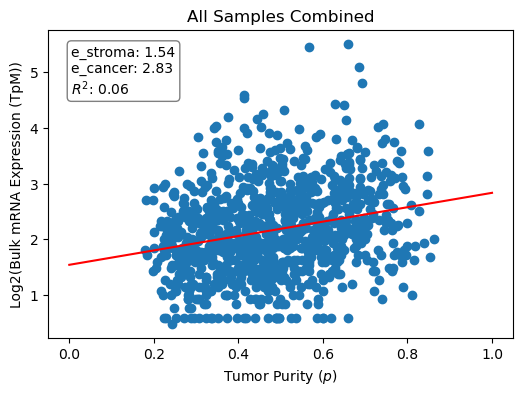

In [90]:
# Run on all samples together
run_deconvolution(tissue_cancer_only_df, 'NM_001256534.2_TpM', by_subtype=False)

#### Lung Tissue by Immune Type

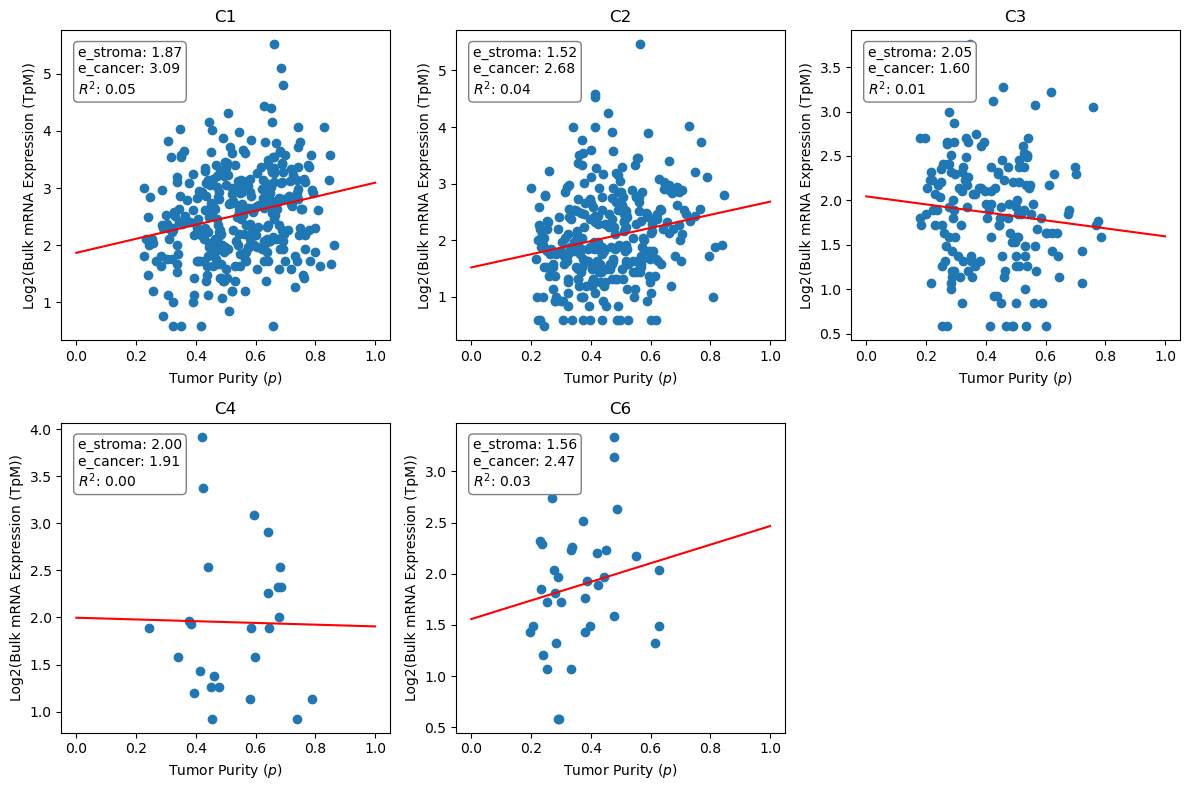

In [91]:
run_deconvolution(tissue_cancer_only_df, 'NM_001256534.2_TpM', by_subtype=True)

### Breast Tissue

In [92]:
# Isolate appropriate tissue samples
tissue_type = 'breast'
tissue_df, tissue_cancer_only_df = isolate_tissue_and_adjust_df(merged_df, tissue_type)

#### All Breast Tissue Samples

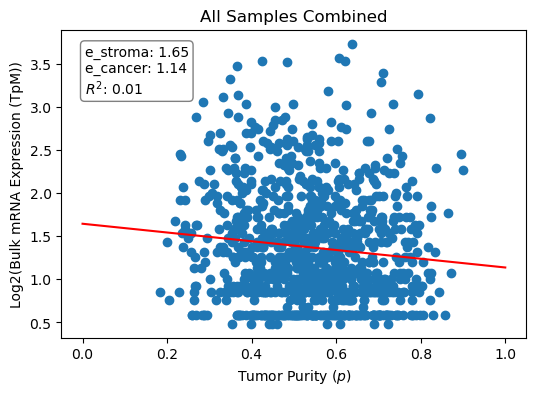

In [93]:
# Run on all samples together
run_deconvolution(tissue_cancer_only_df, 'NM_001256534.2_TpM', by_subtype=False)

#### Breast Tissue by Immune Type

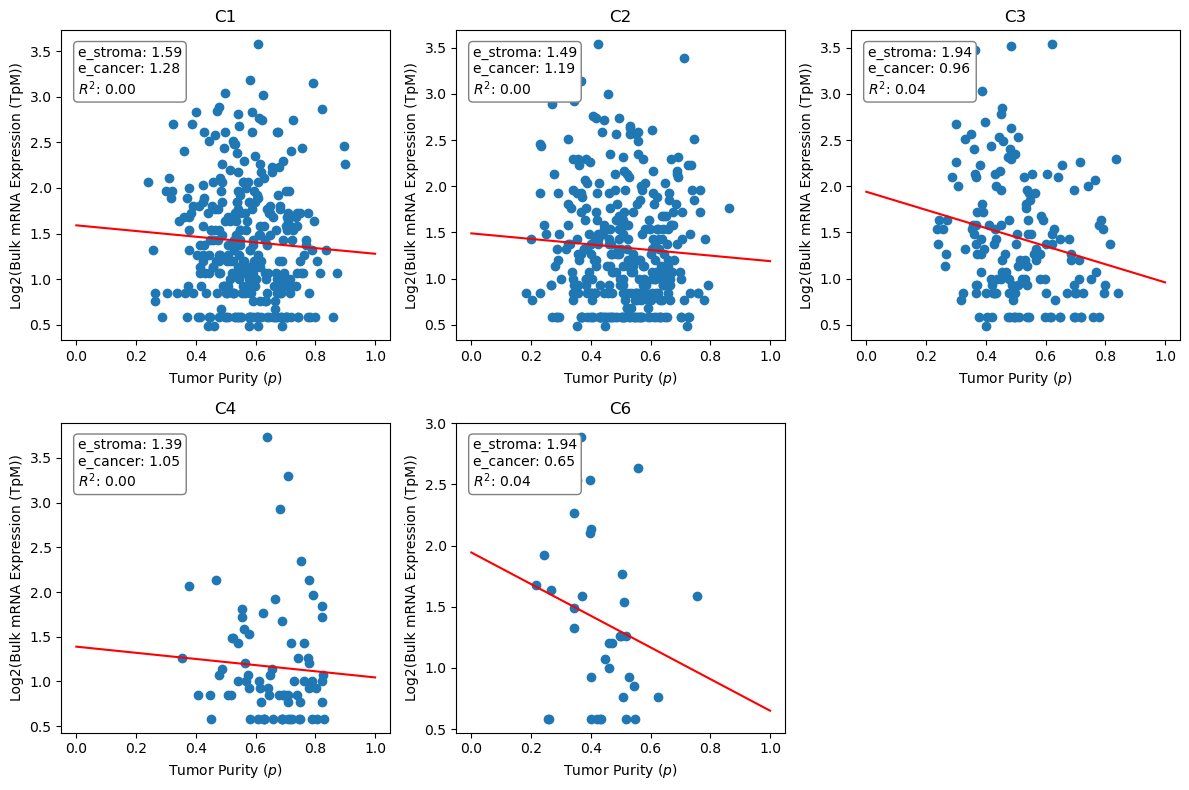

In [94]:
run_deconvolution(tissue_cancer_only_df, 'NM_001256534.2_TpM', by_subtype=True)

**Summary:**

- All r^2 values are very low (<= 0.06).  Hard to make clean interpretations
- Lung tissue shows higher pmCiC is associated with cancer cells
- Breast tissue shows higher pmCiC is associated with stromal cells 
- Inconsistent results between lung and breast tissue suggest unlikely trend


**Takeaway from Linear Deconvolution:**

*No obvious difference in pmCiC expression between stromal and cancer cells.  pmCiC subtype differences is still unexplained.*.

---

## **7. Survival Analysis**

In this section, we want to explore if pmCiC proprotion has any impact on survival by utilizing Kaplan-Meier curves.

- We will use `DSS` (disease specific survival) as the surival metric

**Analysis:**

- Plot survival analysis on comparisons of choice
    - Bucket pmCiC into low/med/high to see if correlation exists across entire tissue type
    - Compare survival across mRNA subtypes and immune subtypes
- Perform pairwise log-rank test to determine significance
    - Correct with local Bonferonni correction for each analysis


### Prepare Plots for Survival Analysis

In [95]:
def plot_survival_single_subtype(df, subtype, subtype_name=''):
    
    # Remove cases where DSS column is np.nan
    DSS_df = df.dropna(subset=['DSS', 'DSS.time'])

    # Select column for disease specific survival
    time_column = 'DSS.time'  
    event_column = 'DSS' 

    # Rename columns to standard 'event' and 'time' for Surv.from_dataframe
    DSS_df = DSS_df.rename(columns={event_column: 'event', time_column: 'time'})

    # Create the structured array for survival analysis
    data = Surv.from_dataframe(event='event', time='time', data=DSS_df)

    # Determine the list of immune types
    subtypes = list(DSS_df[subtype].value_counts().index)

    for sub_type in subtypes:
        # Create a mask for current subtype and sample count
        mask = DSS_df[subtype] == sub_type
        n_samples = mask.sum()

        # Compute Kaplan-Meier estimator with confidence intervals
        time, survival_prob, conf_int = kaplan_meier_estimator(
            data["event"][mask], data["time"][mask], conf_type="log-log")

        plt.step(time, survival_prob, where="post", label=f"{sub_type} (n={n_samples})")
        plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

    plt.title(f'({tissue_type.capitalize()}) Survival Probability by {subtype_name}')
    plt.ylim(0, 1)
    plt.ylabel(r"Survival Probability $\hat{S}(t)$")
    plt.xlabel("time $t$ (days)")
    plt.legend(loc="best")
    plt.show()

In [104]:
def plot_survival_single_subtype_with_pvalue(df, subtype, subtype_name=''):
    # Remove cases where DSS column is np.nan
    DSS_df = df.dropna(subset=['DSS', 'DSS.time'])

    # Select column for disease specific survival
    time_column = 'DSS.time'  
    event_column = 'DSS' 

    # Rename columns to standard 'event' and 'time' for Surv.from_dataframe
    DSS_df = DSS_df.rename(columns={event_column: 'event', time_column: 'time'})

    # Create the structured array for survival analysis
    data = Surv.from_dataframe(event='event', time='time', data=DSS_df)

    # Determine the list of subtypes
    subtypes = list(DSS_df[subtype].value_counts().index)

    # Initialize KaplanMeierFitter object
    kmf = KaplanMeierFitter()

    # Store the survival data for each subtype
    survival_data = {}
    p_values = []
    tests = []  # To track the pairs of subtypes
    
    # Iterate through subtypes and plot each
    for sub_type in subtypes:
        # Create a mask for the current subtype and sample count
        mask = DSS_df[subtype] == sub_type
        n_samples = mask.sum()

        # Fit the Kaplan-Meier estimator for the current subtype
        kmf.fit(DSS_df["time"][mask], DSS_df["event"][mask], label=f"{sub_type} (n={n_samples})")
        kmf.plot_survival_function()

        # Store the time and event data for log-rank test
        survival_data[sub_type] = (DSS_df["time"][mask], DSS_df["event"][mask])

    plt.title(f'({tissue_type.capitalize()}) Survival Probability by {subtype_name}')
    plt.ylim(0, 1)
    plt.ylabel(r"Survival Probability $\hat{S}(t)$")
    plt.xlabel("time $t$ (days)")
    plt.legend(loc="best")
    plt.show()

    # Perform pairwise log-rank tests between all subtypes
    print("\nLog-rank test results (Bonferroni corrected):")
    for i, subtype_1 in enumerate(subtypes):
        for subtype_2 in subtypes[i + 1:]:
            time_1, event_1 = survival_data[subtype_1]
            time_2, event_2 = survival_data[subtype_2]

            # Perform log-rank test between subtype_1 and subtype_2
            results = logrank_test(time_1, time_2, event_observed_A=event_1, event_observed_B=event_2)
            
            # Store p-values for Bonferroni correction
            p_values.append(results.p_value)
            tests.append(f"{subtype_1} vs {subtype_2}")  # Store the names of the subtypes being compared

    # Bonferroni correction
    bonferroni_corrected_p_values = [p * len(p_values) for p in p_values]  # Multiply by number of tests

    # Print Bonferroni corrected p-values along with the subtype comparison
    for idx, (test, p_value, corrected_p_value) in enumerate(zip(tests, p_values, bonferroni_corrected_p_values)):
        if corrected_p_value >= 1: corrected_p_value = 1 # Limit the p-value to a max of 1
        print(f"{test}: p-value = {p_value:.4f}, Bonferroni corrected p-value = {corrected_p_value:.4f}")

In [86]:
def plot_survival_multiple_subtypes(df, main_group, inner_group, main_group_name='', inner_group_name='', 
                             fig_col_size=5, fig_row_size=5, tissue_type=''):
    """
    Plots survival analysis for different main groups and inner subgroups on the same axes.

    Parameters:
    - df: DataFrame containing the survival data.
    - main_group: Column name to group by on the main level (e.g., immune type).
    - inner_group: Column name for the subgroups to split within each main group.
    - main_group_name: Name for the main grouping variable (for plot title).
    - inner_group_name: Name for the inner grouping variable (for legend labels).
    """
    
    # Remove cases where DSS column is np.nan
    DSS_df = df.dropna(subset=['DSS', 'DSS.time'])

    # Ensure DSS (event) column is binary (0 or 1 only)
    DSS_df = DSS_df[DSS_df['DSS'].isin([0, 1])]

    # Select column for disease specific survival
    time_column = 'DSS.time'
    event_column = 'DSS'

    # Rename columns to standard 'event' and 'time' for Surv.from_dataframe
    DSS_df = DSS_df.rename(columns={event_column: 'event', time_column: 'time'})

    # Create the structured array for survival analysis
    data = Surv.from_dataframe(event='event', time='time', data=DSS_df)

    # Get the unique values in the main group column
    main_groups = DSS_df[main_group].unique()
    main_groups = sorted(list(DSS_df[main_group].value_counts().index))

    # Plot results
    # Determine the optimal grid size (rows and columns)
    num_plots = len(main_groups)
    cols = int(np.ceil(np.sqrt(num_plots)))  # Optimal number of columns
    rows = int(np.ceil(num_plots / cols))    # Optimal number of rows

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(fig_col_size * cols, fig_row_size * rows))

    # Convert axes to at least 2D, even if rows=1 or columns=1
    axes = np.atleast_2d(axes)

    # Flatten the axes array in case of multi-row and multi-column grids
    axes = axes.flatten()

    # Loop through each main group (e.g., immune type)
    for i,group in enumerate(main_groups):
        # Filter the data for the main group
        main_group_df = DSS_df[DSS_df[main_group] == group]
        data_main_group = Surv.from_dataframe(event='event', time='time', data=main_group_df)
        
        # Get the unique values in the inner group column
        inner_groups = main_group_df[inner_group].unique()

        # Loop through each inner group (e.g., subtypes within immune type)
        for inner in inner_groups:
            mask = main_group_df[inner_group] == inner
            n_samples = mask.sum()  # Count samples for this subgroup

            # Compute Kaplan-Meier estimator with confidence intervals
            time, survival_prob, conf_int = kaplan_meier_estimator(
                data_main_group["event"][mask], data_main_group["time"][mask], conf_type="log-log")

            # Plot each survival curve with main group and inner group labels
            axes[i].step(time, survival_prob, where="post", label=f"{inner} (n={n_samples})")
            axes[i].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

        # Plot settings
        axes[i].set_title(f'{tissue_type.capitalize()} - {main_group_name}: {group}')
        axes[i].set_ylim(0, 1)
        axes[i].set_ylabel(r"Survival Probability $\hat{S}(t)$")
        axes[i].set_xlabel("Time (Days)")
        axes[i].legend(loc="best")
    
    # Remove unused axes
    for j in range(i+1, rows*cols):
        fig.delaxes(axes[j])

    # Show figure as output
    plt.tight_layout()
    plt.show()

### Lung Tissue

In [105]:
# Isolate appropriate tissue samples
tissue_type = 'lung'
tissue_df, tissue_cancer_only_df = isolate_tissue_and_adjust_df(merged_df, tissue_type)

Based on our above exploratory data analysis we will statistically test each of the relationships we saw for Lung and Breast tissue types.

#### Low/Med/High Tissue Samples

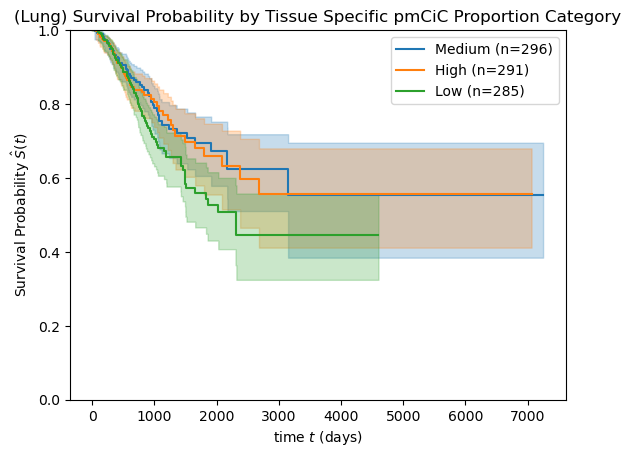


Log-rank test results (Bonferroni corrected):
Medium vs High: p-value = 0.7482, Bonferroni corrected p-value = 1.0000
Medium vs Low: p-value = 0.0336, Bonferroni corrected p-value = 0.1009
High vs Low: p-value = 0.0932, Bonferroni corrected p-value = 0.2797


In [109]:
plot_survival_single_subtype_with_pvalue(tissue_cancer_only_df, subtype='tissue_specific_pmCiC_category', subtype_name='Tissue Specific pmCiC Proportion Category')

#### Immune SubType

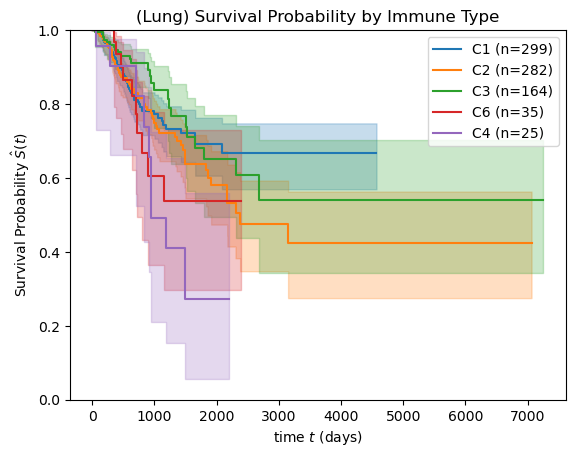


Log-rank test results (Bonferroni corrected):
C1 vs C2: p-value = 0.2380, Bonferroni corrected p-value = 1.0000
C1 vs C3: p-value = 0.3338, Bonferroni corrected p-value = 1.0000
C1 vs C6: p-value = 0.2794, Bonferroni corrected p-value = 1.0000
C1 vs C4: p-value = 0.0269, Bonferroni corrected p-value = 0.2687
C2 vs C3: p-value = 0.0559, Bonferroni corrected p-value = 0.5587
C2 vs C6: p-value = 0.4762, Bonferroni corrected p-value = 1.0000
C2 vs C4: p-value = 0.0542, Bonferroni corrected p-value = 0.5425
C3 vs C6: p-value = 0.0557, Bonferroni corrected p-value = 0.5575
C3 vs C4: p-value = 0.0029, Bonferroni corrected p-value = 0.0291
C6 vs C4: p-value = 0.5599, Bonferroni corrected p-value = 1.0000


In [107]:
plot_survival_single_subtype_with_pvalue(tissue_cancer_only_df, subtype='Subtype_Immune_Model_Based', subtype_name='Immune Type')

#### mRNA Subtype

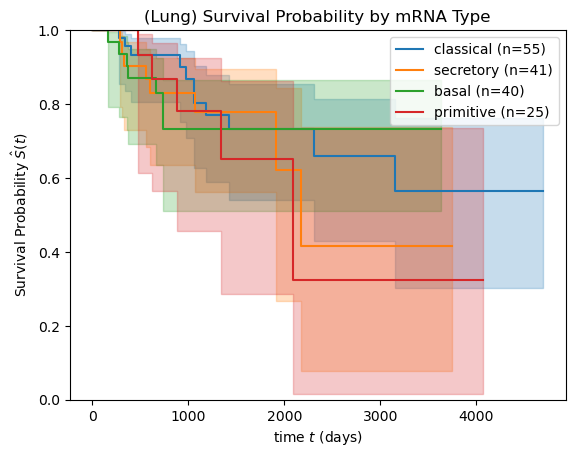


Log-rank test results (Bonferroni corrected):
classical vs secretory: p-value = 0.4764, Bonferroni corrected p-value = 1.0000
classical vs basal: p-value = 0.7351, Bonferroni corrected p-value = 1.0000
classical vs primitive: p-value = 0.4215, Bonferroni corrected p-value = 1.0000
secretory vs basal: p-value = 0.7560, Bonferroni corrected p-value = 1.0000
secretory vs primitive: p-value = 0.8422, Bonferroni corrected p-value = 1.0000
basal vs primitive: p-value = 0.7041, Bonferroni corrected p-value = 1.0000


In [108]:
plot_survival_single_subtype_with_pvalue(tissue_cancer_only_df, subtype='Subtype_mRNA', subtype_name='mRNA Type')

### Breast Tissue

In [110]:
# Isolate appropriate tissue samples
tissue_type = 'breast'
tissue_df, tissue_cancer_only_df = isolate_tissue_and_adjust_df(merged_df, tissue_type)

#### Low/Med/High Tissue Samples

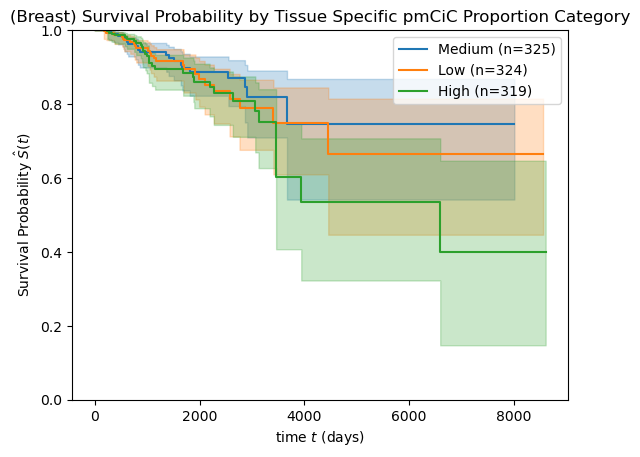


Log-rank test results (Bonferroni corrected):
Medium vs Low: p-value = 0.5732, Bonferroni corrected p-value = 1.0000
Medium vs High: p-value = 0.1918, Bonferroni corrected p-value = 0.5755
Low vs High: p-value = 0.4257, Bonferroni corrected p-value = 1.0000


In [111]:
plot_survival_single_subtype_with_pvalue(tissue_cancer_only_df, subtype='tissue_specific_pmCiC_category', subtype_name='Tissue Specific pmCiC Proportion Category')

#### Immune SubType

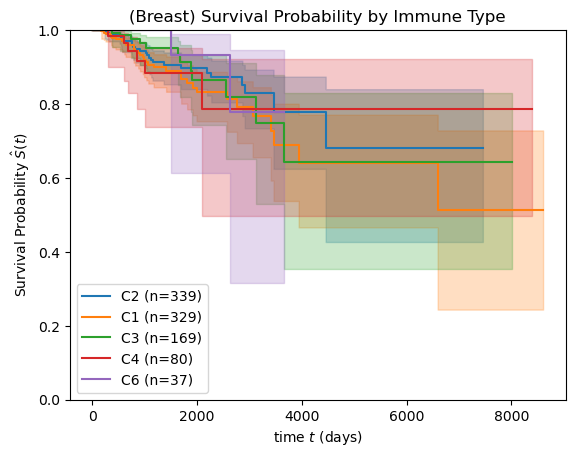


Log-rank test results (Bonferroni corrected):
C2 vs C1: p-value = 0.2240, Bonferroni corrected p-value = 1.0000
C2 vs C3: p-value = 0.9219, Bonferroni corrected p-value = 1.0000
C2 vs C4: p-value = 0.4759, Bonferroni corrected p-value = 1.0000
C2 vs C6: p-value = 0.6670, Bonferroni corrected p-value = 1.0000
C1 vs C3: p-value = 0.2985, Bonferroni corrected p-value = 1.0000
C1 vs C4: p-value = 0.9787, Bonferroni corrected p-value = 1.0000
C1 vs C6: p-value = 0.3593, Bonferroni corrected p-value = 1.0000
C3 vs C4: p-value = 0.3450, Bonferroni corrected p-value = 1.0000
C3 vs C6: p-value = 0.6041, Bonferroni corrected p-value = 1.0000
C4 vs C6: p-value = 0.3185, Bonferroni corrected p-value = 1.0000


In [112]:
plot_survival_single_subtype_with_pvalue(tissue_cancer_only_df, subtype='Subtype_Immune_Model_Based', subtype_name='Immune Type')

#### mRNA Subtype

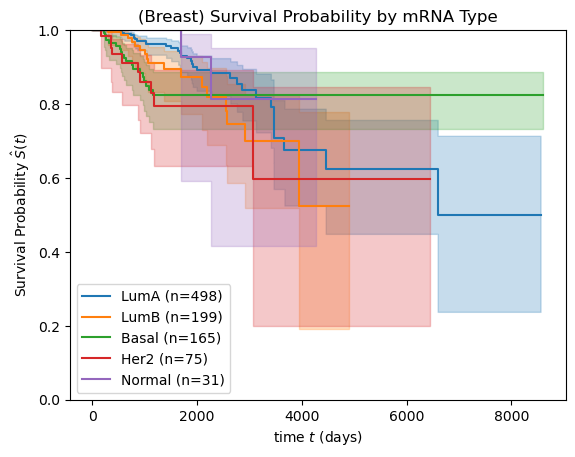


Log-rank test results (Bonferroni corrected):
LumA vs LumB: p-value = 0.0571, Bonferroni corrected p-value = 0.5709
LumA vs Basal: p-value = 0.0619, Bonferroni corrected p-value = 0.6194
LumA vs Her2: p-value = 0.0018, Bonferroni corrected p-value = 0.0183
LumA vs Normal: p-value = 0.8099, Bonferroni corrected p-value = 1.0000
LumB vs Basal: p-value = 0.6243, Bonferroni corrected p-value = 1.0000
LumB vs Her2: p-value = 0.1917, Bonferroni corrected p-value = 1.0000
LumB vs Normal: p-value = 0.2869, Bonferroni corrected p-value = 1.0000
Basal vs Her2: p-value = 0.4898, Bonferroni corrected p-value = 1.0000
Basal vs Normal: p-value = 0.2371, Bonferroni corrected p-value = 1.0000
Her2 vs Normal: p-value = 0.1222, Bonferroni corrected p-value = 1.0000


In [113]:
plot_survival_single_subtype_with_pvalue(tissue_cancer_only_df, subtype='Subtype_mRNA', subtype_name='mRNA Type')

#### Survival Analysis Summary:

##### **Lung Tissue:**

- **Low/Medium/High Grouping:** No significant differences observed between groups.
- **mRNA Subgroup Analysis:** No discernible trends observed.
- **Immune Type Breakdown:** 
    - **Median mRNA Expression:** C1 > C2 ~ C3 > C4 ~ C6
    - **Qualitative Survival:** C1 > C2 ~ C3 ~ C6 > C4
    - **Significant Pairwise Comparison:** C3 vs C4 (p=0.029)



##### **Breast Tissue:**

- **Low/Medium/High Grouping:** No significant differences observed between groups.
- **mRNA Subgroup Analysis:**
    - **Median mRNA Expression:** Normal > Basal > LumA > Her2 > LumB.
    - **Qualitative Survival:** Normal ~ Basal > LumA ~ Her2 ~ LumB.
    - **Significant Pairwise Comparison:** LumA vs Her2 (p = 0.018).
- **Immune Type Breakdown:** No discernible trends observed. 

Qualitatively, the samples with the most pmCiC had the longest survival times.  This is counter to our hypothesis, as we expect higher pmCiC to translate to more rapidly reproducing and aggressive cancers, leading to shorter surivival times.

Statistically, there is very minimal signficance between groups, and none that suggest higher pmCiC proportion lead to shorter survival times.

---

## **8. Summary and Next Steps**

## Summary

This project investigated the role of alternative splicing in the expression and activity of the plasma membrane citrate transporter (pmCiC) and its implications for cancer metabolism. By leveraging transcriptomic data from The Cancer Genome Atlas (TCGA), we performed a comprehensive analysis of pmCiC expression patterns across various cancer types and normal tissues. Key findings include:

- **General Upregulation:** Both pmCiC and mitochondrial citrate transporter (mCiC) are significantly upregulated in tumor tissues compared to normal tissues, highlighting their potential role in supporting cancer cell metabolism
- **Tissue-Specific Differences:** The proportion of pmCiC to mCiC was significantly higher in specific tissue types, notably lung and breast cancers, indicating tissue-specific metabolic adaptations
- **Subtype-Specific Trends:** Differential expression patterns were identified in specific subgroups, such as Basal and Normal mRNA subtypes in breast cancer and the C1 immune subtype in lung cancer
- **Tumor Stage Impact:** Interestingly, pmCiC proportions were not significantly associated with tumor stage across the analyzed samples
- **Survival Insights:** Contrary to expectations, higher pmCiC proportions were not associated with poorer survival outcomes, suggesting a nuanced role for pmCiC in cancer progression
- **Tumor-Stromal Interplay:** Linear deconvolution analysis indicated no clear trends in tumor versus stromal contributions to pmCiC expression in breast and lung tissues

The project's findings provide insights into the role of alternative splicing in cancer metabolism and highlight the potential for additional research before using pmCiC as a target for therapeutic interventions.

## Next Steps

Building on the results of this study, future research directions and potential expansions include:

1. **Validation with Long-Read Sequencing:**
   - Use long-read sequencing techniques to confirm the presence and relative abundances of pmCiC and mCiC transcripts in breast and lung cancer samples
   - Investigate the isoform-specific splicing events at a finer resolution

2. **Explore Additional Datasets:**
   - Incorporate independent datasets, such as the International Cancer Genome Consortium (ICGC) or cancer cell line datasets (e.g., CCLE), to validate and generalize findings across broader cancer contexts
   - Perform cross-dataset analyses to strengthen statistical robustness and reproducibility

3. **Functional Validation in Experimental Models:**
   - Conduct laboratory experiments using cancer cell lines to assess the functional impact of pmCiC overexpression or knockdown on cell metabolism and growth
   - Investigate the metabolic consequences of altering pmCiC proportions, particularly in lipid biosynthesis and energy production

4. **Integration with Multiomics Data:**
   - Incorporate proteomics, metabolomics, and epigenomics data to provide a holistic view of pmCiC's role in cancer metabolism
   - Investigate how changes in pmCiC expression interact with other metabolic pathways and tumor microenvironment factors


---

## **9. Acknowledgements**

The results shown here are in whole or part based upon data generated by the TCGA Research network: [https://www.cancer.gov/tcga](https://www.cancer.gov/tcga).

Additionally, this research builds upon findings from the study:

*"Pan-Cancer Analysis of Ligand–Receptor Cross-talk in the Tumor Microenvironment"* (Cancer Res, 2021, 81(7):1802–1812) by Ghoshdastider et al.

A special thank you to Rohit Reja and Neha Rohatgi for their guidance and expertise as scientific advisors throughout this project. Their insights on experimental design and future directions have been instrumental in shaping our work.


---

# Appendix

## **A1. Machine Learning Model Development** 
This section demonstrates the machine learning pipeline that would have been used to predict tumor stage using pmCiC proportions and additional phenotypic data, had the feature shown statistical significance. While the study determined that pmCiC proportions do not have a significant impact on tumor stage, this exercise serves to illustrate the methodology for feature analysis, feature engineering, and model development.

The purpose of this section is twofold:
1. **Educational Demonstration:** To showcase the process of building and evaluating machine learning models, including feature analysis, engineering, and comparison of model performance
2. **Comparative Analysis:** To highlight the strengths and weaknesses of various machine learning algorithms, such as Gradient Boosted Trees (GBT), Neural Networks, Support Vector Machines (SVMs), and k-Nearest Neighbors (k-NN), in handling structured phenotypic data

Although the specific feature (pmCiC proportion) did not prove useful, this section provides a robust framework for approaching similar predictive modeling problems in cancer research and beyond.


### Investigate Features

In [54]:
numerical_main = ['NM_001256534.2_TpM', 'NM_001287387.2_TpM', 'NM_005984.5_TpM', 'NM_005984.5_proportion', 
                  'NM_001287387.2_proportion', 'NM_001256534.2_proportion']

categorical_main = ['tissue_type', 'disease_type', 'gender', 'race', 'age_binned']

categorical_subtypes = ['menopause_status', 'Subtype_Immune_Model_Based', 'Subtype_mRNA', 'Subtype_DNAmeth', 
                        'Subtype_protein', 'Subtype_miRNA', 'Subtype_CNA', 'Subtype_Integrative', 'Subtype_other', 
                        'Subtype_Selected']

outcome_variable = ['binned_stage']

In [55]:
def adjust_columns_for_ML(df):
    '''Preprocess the dataframe to prepare for ML analysis'''
    # Add 'Non-Cancerous' to the categories of the 'binned_stage' column
    df['binned_stage'] = df['binned_stage'].cat.add_categories(['Non-Cancerous'])

    # Assign 'Non-Cancerous' to the rows where 'source_type' is 'TCGA_normal'
    # TCGA assigned stage for normal cells to be consisent with the corresponding cancer sample
    df.loc[df['source_type'] == 'TCGA_normal', 'binned_stage'] = 'Non-Cancerous'

    # Drop the columns without any labeled stage
    df = df[~df['binned_stage'].isna()]

    return df

In [ ]:
# Load an ML specific dataframe
ML_df = merged_df.copy()
ML_df = adjust_columns(ML_df)
ML_df = adjust_columns_for_ML(ML_df)

### Numerical Feature impact on Outcome
- Create box plots for each numerical feature with the outcome categories on the x-axis
- Create a correlation matrix between the numerical features

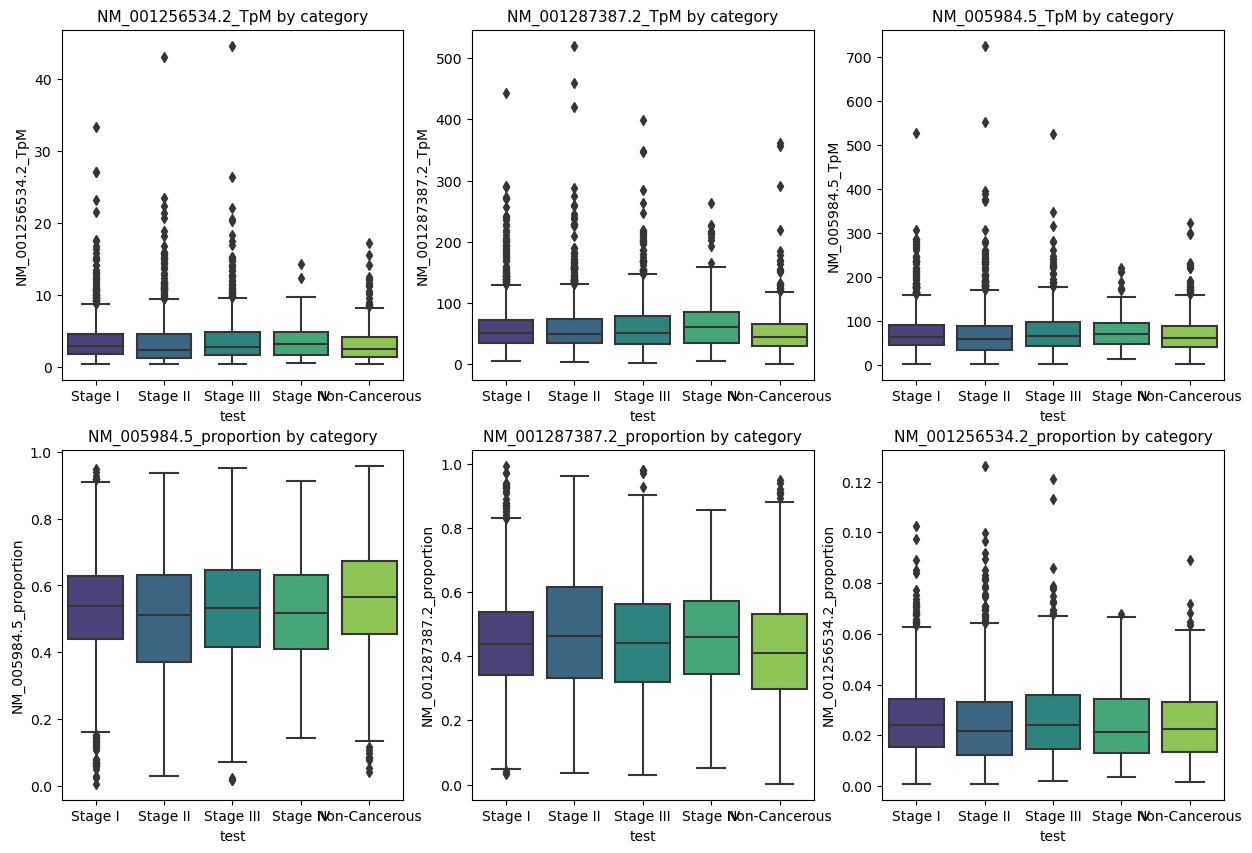

In [ ]:
ML_df_numerical = ML_df[numerical_main + outcome_variable]

fig, axes = plt.subplots(2,3,figsize=(15,10))
axes = axes.flatten()
for i,numerical_category in enumerate(numerical_main):

    sns.boxplot(ax=axes[i],x="binned_stage", y=numerical_category, data=ML_df_numerical, palette='viridis')

    axes[i].set_xlabel('test')
    axes[i].set_title(f'{numerical_category} by category', size=11)


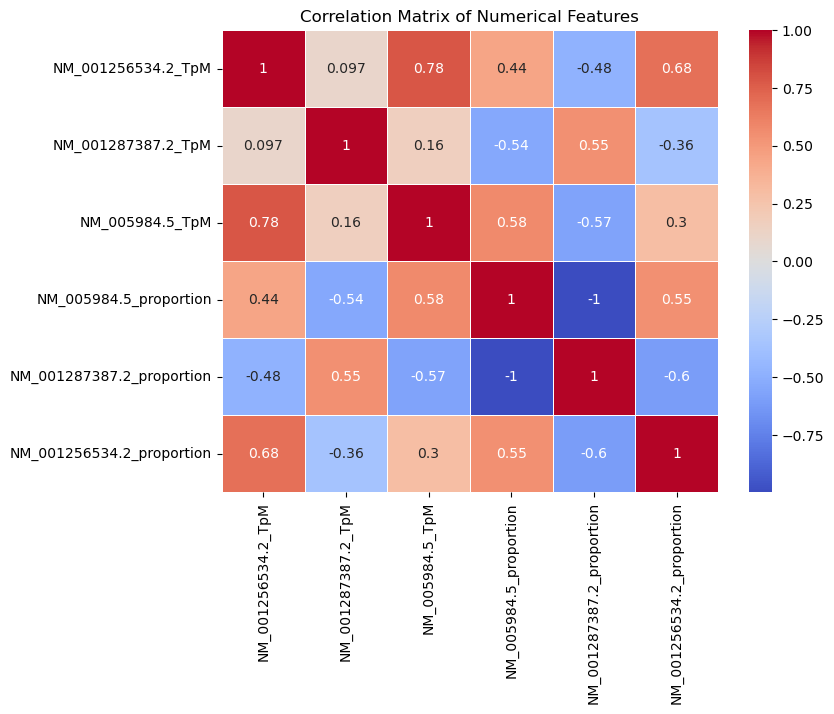

In [60]:
# calculate the correlation matrix
corr = ML_df_numerical[numerical_main].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)

# Show the plot
plt.title('Correlation Matrix of Numerical Features')
plt.show()

**Summary**: 
- The box plots show minimal variation in numerical features across tumor stages, suggesting limited impact on predicting tumor stage
- The correlation matrix highlights strong relationships between certain features, such as NM_005984.5_TpM and NM_001256534.2_TpM, which may inform feature engineering strategies



### Observe Distributions of Numerical Features
- Plot the distribution for each numerical feature
- Rescale numerical features of interest

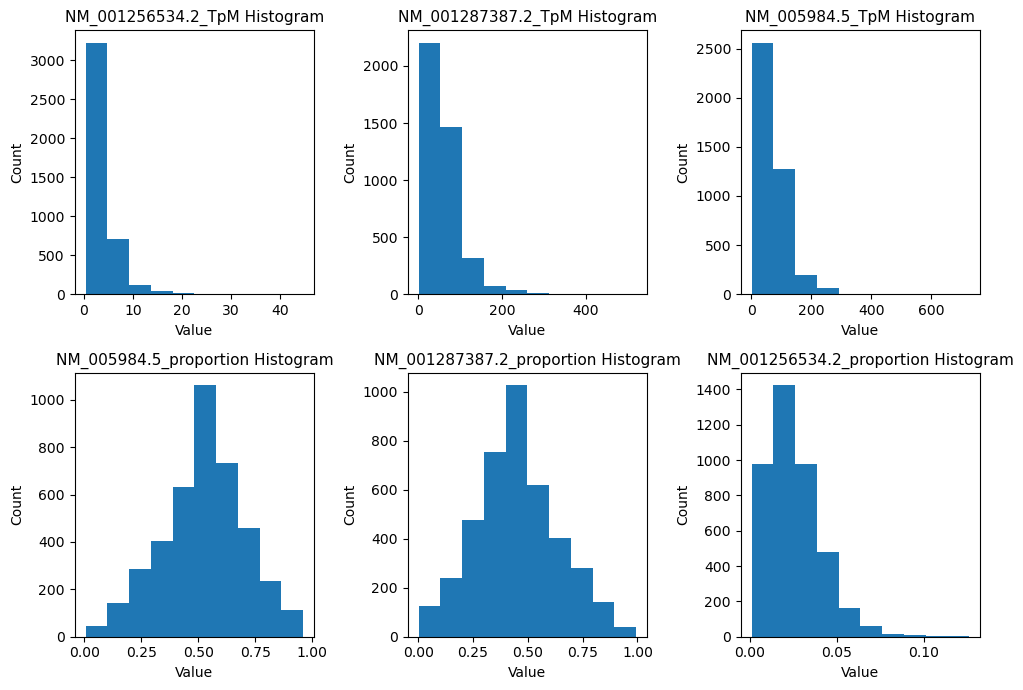

In [61]:
# Plot the regular features
fig, axes = plt.subplots(2,3,figsize=(10,7))
axes = axes.flatten()
for i,numerical_category in enumerate(numerical_main):

    axes[i].hist(ML_df[numerical_category])

    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'{numerical_category} Histogram', size=11)

plt.tight_layout()
plt.show()

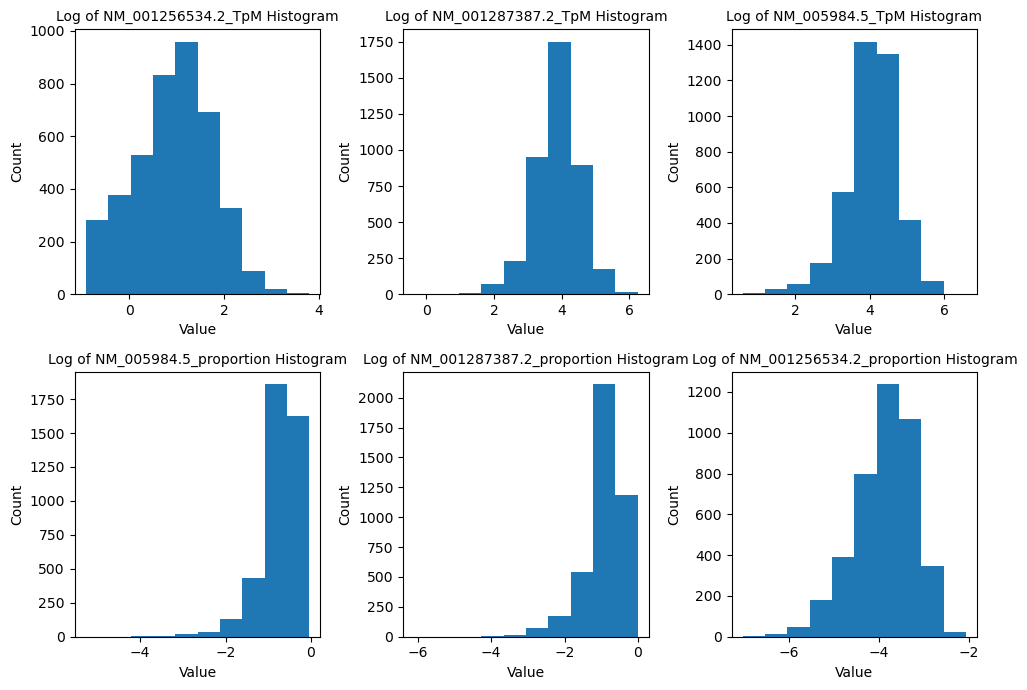

In [62]:
# Plot the Log version of features
fig, axes = plt.subplots(2,3,figsize=(10,7))
axes = axes.flatten()
for i,numerical_category in enumerate(numerical_main):

    # Add a log version of the numerical category
    ML_df[f'{numerical_category}_log'] = ML_df[numerical_category].apply(lambda x: np.log(x))

    # Plot the log version
    axes[i].hist(ML_df[f'{numerical_category}_log'])

    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'Log of {numerical_category} Histogram', size=10)

plt.tight_layout()
plt.show()

**Summary**:
- Select 6534.2 TpM & 6534.2 proportion as feature values
    - select the log versions of each variable 
    - Normalize both values

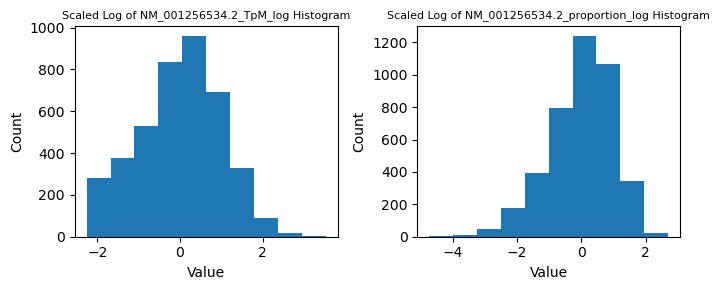

In [63]:
numerical_selected = ['NM_001256534.2_TpM_log', 'NM_001256534.2_proportion_log']

for numerical_feature in numerical_selected:
    ML_df[f'{numerical_feature}_scaled'] = (ML_df[numerical_feature] - ML_df[numerical_feature].mean()) / ML_df[numerical_feature].std()

# Plot the Log version of features
fig, axes = plt.subplots(1,2,figsize=(7,3))
axes = axes.flatten()
for i,numerical_category in enumerate(numerical_selected):

    # Plot the log version
    axes[i].hist(ML_df[f'{numerical_category}_scaled'])

    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'Scaled Log of {numerical_category} Histogram', size=8)

plt.tight_layout()
plt.show()

### Categorical Feature Impact on Outcome
- Plot the count of number of samples for each subtype for each outcome category

In [64]:
ML_df_categorical = ML_df[categorical_main + outcome_variable]
ML_df_categorical.head()

,tissue_type,disease_type,gender,race,age_binned,binned_stage
0,liver,LIHC,FEMALE,WHITE,70-80,Non-Cancerous
1,lung,LUAD,FEMALE,WHITE,60-70,Stage III
2,breast,BRCA,FEMALE,WHITE,50-60,Stage II
3,kidney,KICH,MALE,WHITE,40-50,Stage I
4,breast,BRCA,FEMALE,ASIAN,70-80,Stage III


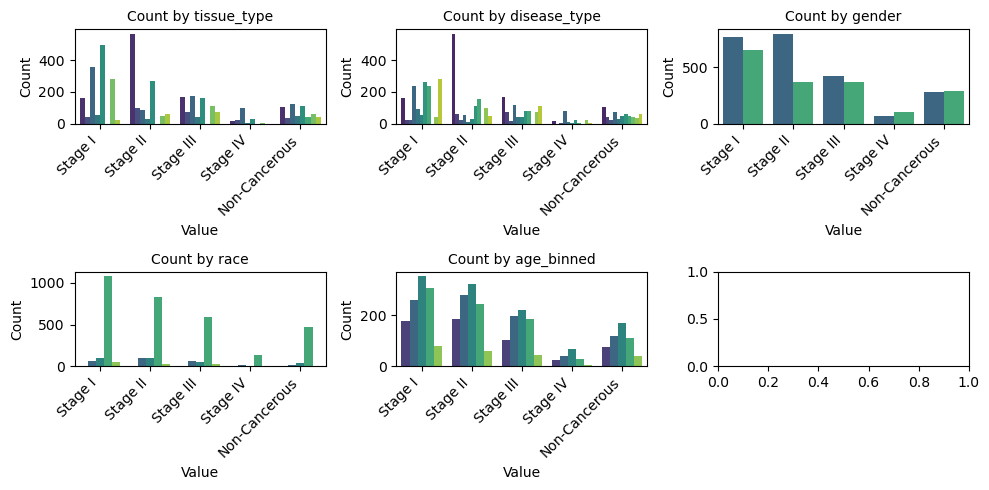

In [ ]:
# Plot the Log version of features
fig, axes = plt.subplots(2,3,figsize=(10,5))
axes = axes.flatten()

for i,categorical_category in enumerate(categorical_main):

    # Create a grouped df to get the count of each breakdown of data
    df_grouped = ML_df_categorical.groupby(['binned_stage', categorical_category]).size().reset_index(name='count')

    # Plot the log version
    sns.barplot(ax=axes[i], x='binned_stage', y='count', data=df_grouped, hue=categorical_category, palette='viridis')

    # Suppress the legend
    axes[i].legend_.remove()

    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'Count by {categorical_category}', size=10)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')


plt.tight_layout()
plt.show()

**Summary**:
- These figures are difficult to interpret because they are based on overall count instead of proportion.  i.e. The database is mostly one race, so in the "Count by Race" category, it's challengeing to interpret the impact on other races 
- Normalize the results and replot based on overall proportion

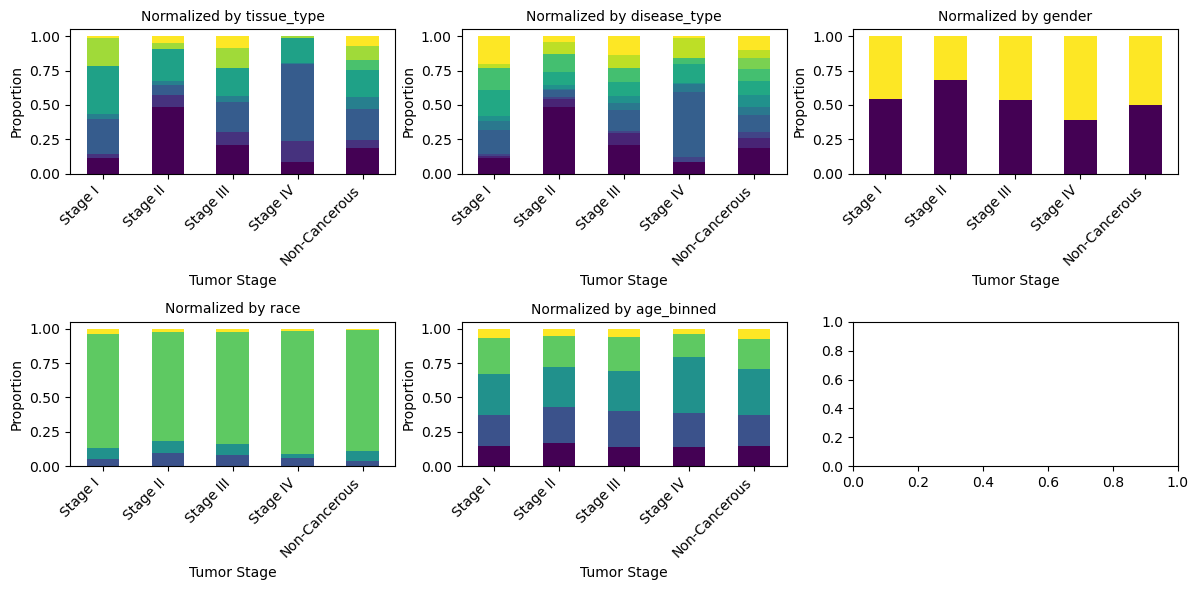

In [ ]:

# Normalize the counts within each 'binned_stage'
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, categorical_category in enumerate(categorical_main):

    # Create a grouped df to get the count of each breakdown of data
    df_grouped = ML_df_categorical.groupby(['binned_stage', categorical_category]).size().reset_index(name='count')

    # Pivot and normalize the data
    df_pivot = df_grouped.pivot_table(index='binned_stage', columns=categorical_category, values='count', fill_value=0)
    df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)  # Normalize by row (binned_stage)

    # Plot stacked bar chart
    df_pivot.plot(kind='bar', stacked=True, ax=axes[i], colormap='viridis')

            # Suppress the legend
    axes[i].legend_.remove()

    axes[i].set_xlabel('Tumor Stage')
    axes[i].set_ylabel('Proportion')
    axes[i].set_title(f'Normalized by {categorical_category}', size=10)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


**Summary**:
- Here we are looking for differences in color profile between stages
- The qualitatively important categorical values based on these plots are:
    - `tissue_type`
    - `disease_type`
    - `gender`
    - `race`
- `age_binned` does not have much impact on the outcome variable

### One Hot Encode Categorical Variables
Use scikitlearn to convert the selected categorical variables to one hot encoded variables.

In [424]:
numerical_final = ['NM_001256534.2_TpM_log_scaled', 'NM_001256534.2_proportion_log_scaled']
categorical_final = ['tissue_type', 'disease_type', 'gender', 'race']

In [470]:
# Convert variables to ohe
encoded_dfs = []

for category in categorical_final:

    # Create and fit a one hot encoder for a given column
    ohe = OneHotEncoder(sparse_output=False)
    test_output = ohe.fit_transform(ML_df[category].to_numpy().reshape(-1,1))

    # Collect column names from the encoder
    column_labels = ohe.get_feature_names_out()
    column_names = [category + '_' + col_label.split('_')[1] for col_label in column_labels]

    # Convert result to df with proper column names
    encoded_dfs.append(pd.DataFrame(test_output, columns = column_names))

# Combine ohe variables into one df
ohe_df = pd.concat(encoded_dfs, axis=1).reset_index(drop=True)

# Merge with numerical data
num_df = ML_df[numerical_final + outcome_variable].reset_index(drop=True)
transformed_df = pd.concat([num_df, ohe_df], axis=1)
transformed_df.head()

,NM_001256534.2_TpM_log_scaled,NM_001256534.2_proportion_log_scaled,binned_stage,tissue_type_adrenal,tissue_type_bladder,tissue_type_breast,tissue_type_cervix,tissue_type_colorectal,tissue_type_gastric,tissue_type_kidney,tissue_type_liver,tissue_type_lung,tissue_type_pancreas,tissue_type_prostate,tissue_type_skin,tissue_type_soft,tissue_type_thyroid,tissue_type_upper,tissue_type_uterus,disease_type_ACC,disease_type_BLCA,disease_type_BRCA,disease_type_CESC,disease_type_COAD,disease_type_HNSC,disease_type_KICH,disease_type_KIRC,disease_type_KIRP,disease_type_LIHC,disease_type_LUAD,disease_type_LUSC,disease_type_PAAD,disease_type_PRAD,disease_type_READ,disease_type_SARC,disease_type_SKCM,disease_type_STAD,disease_type_THCA,disease_type_UCEC,gender_FEMALE,gender_MALE,gender_nan,race_AMERICAN INDIAN,race_ASIAN,race_BLACK,race_WHITE,race_[Unknown],race_nan
0,1.245370,1.060964,Non-Cancerous,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.040015,0.852116,Stage III,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.092224,0.237298,Stage II,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.604577,0.256421,Stage I,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.786551,0.482068,Stage III,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Data Partitioning

In [490]:
# Prepare the df's
X = transformed_df.drop(columns='binned_stage')  # Drop 'binned_stage' from the feature matrix
y = transformed_df['binned_stage']  # Target variable

# Set up label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split Train first.  Then split test/val 50/50 afterwards.
seed = 7
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

print(f'Initial df was shape: {transformed_df.shape}')
print(f'Train data is shape: {X_train.shape}')
print(f'Validation data is shape: {X_val.shape}')
print(f'Test data is shape: {X_test.shape}')

Initial df was shape: (4972, 48)
Train data is shape: (3480, 47)
Validation data is shape: (746, 47)
Test data is shape: (746, 47)


## Model Selection

- Multiclass classification problem (cannot use binary classifier)
- Available models
    - Decision Tree/Random Forest/GBT
    - Neural net
    - SVM
    - k-nearest neighbor

### Gradient Boosted Classifier

In [ ]:
GBC = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05,
    max_depth=3, random_state=0, min_samples_leaf=2, subsample=1, 
    min_samples_split=5)

GBC.fit(X_train, y_train)

In [536]:
def calculate_accuracy(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    accuracy_train = (y_train_pred == y_train).sum()/len(y_train)
    print(f'Train accuracy: {accuracy_train}')

    y_val_pred = model.predict(X_val)
    accuracy_val = (y_val_pred == y_val).sum()/len(y_val)
    print(f'Validation accuracy: {accuracy_val}')

In [537]:
calculate_accuracy(GBC, X_train, y_train, X_val, y_val)

Train accuracy: 0.5232758620689655
Validation accuracy: 0.44235924932975873


#### Grid Search with GBC
Perform a grid search of the gradient boosted classifiers to identify the optimal hyperparameters.

In [526]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state=0), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)


Best parameters found:  {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 1.0}


### Neural Net

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

In [538]:
calculate_accuracy(mlp_model, X_train, y_train, X_val, y_val)

Train accuracy: 0.6451149425287356
Validation accuracy: 0.42761394101876676


### SVM

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', C=1, gamma='auto', random_state=42)
svm_model.fit(X_train, y_train)

In [540]:
calculate_accuracy(svm_model, X_train, y_train, X_val, y_val)

Train accuracy: 0.47758620689655173
Validation accuracy: 0.44235924932975873


### k-nearest neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

In [542]:
calculate_accuracy(knn_model, X_train, y_train, X_val, y_val)

Train accuracy: 0.5818965517241379
Validation accuracy: 0.39544235924932974


## Results

| Model                     | Train Accuracy | Validation Accuracy |
|---------------------------|----------------|----------------------|
| Gradient Boosted Classifier | 0.5233         | 0.4424               |
| Neural Network             | 0.6451         | 0.4276               |
| Support Vector Machine (SVM) | 0.4776         | 0.4424               |
| k-Nearest Neighbors        | 0.5819         | 0.3954               |

## Conclusion
- The Neural Network achieved the highest training accuracy (64.51%), but its validation accuracy was lower than expected, suggesting overfitting
- Gradient Boosted Classifier and SVM showed similar validation accuracy (44.24%), though Gradient Boosted Classifier had a slightly higher training accuracy
- The k-Nearest Neighbors model had the lowest validation accuracy, indicating it may not generalize well for this dataset

These results highlight the challenges of predictive modeling for this dataset, especially given that pmCiC proportions are known not to impact tumor stage in this dataset.

**It is important to reiterate that the primary goal for this ML section was educational**, demonstrating the end-to-end machine learning workflow, including model training and evaluation. While pmCiC proportions are not useful for predicting tumor stage, this exercise provides a basic framework for applying machine learning techniques to similar problems in cancer research or other domains


## Next Steps / Additional Work

The following steps could be taken to improve the predictive modeling process:

1. **Further Data Exploration:**
   - **Outlier Detection:** Identify and analyze potential outliers in the data, as they may represent biologically significant cases or data entry errors
   - **Data Distribution:** Investigate the distributions of  categorical features in more depth to ensure that preprocessing steps, such as transformations or normalizations, are appropriate
   - **Feature Correlations:** Examine higher-order correlations or interactions between features to uncover hidden relationships that might improve model performance

2. **Hyperparameter Tuning:**
   - Optimize the hyperparameters of each model using techniques such as grid search or Bayesian optimization to improve model performance

3. **Address Class Imbalance:**
   - Investigate the class distribution for tumor stages and apply appropriate oversampling or undersampling techniques if the dataset is imbalanced

4. **Cross-Validation:**
   - Implement k-fold cross-validation to ensure more robust evaluation and minimize overfitting on the training data

5. **Incorporate Biological Context:**
   - Integrate domain knowledge about cancer biology, such as tumor microenvironment characteristics or metabolic pathways, to guide feature engineering and model interpretation

6. **Expand Dataset:**
   - Incorporate additional datasets, such as external cancer genomic data (e.g., ICGC or CCLE), to increase the size and diversity of the training set and improve generalizability

7. **Final Evaluation on Test Data:** 
    - Conduct a final evaluation of the best-performing model on a reserved test dataset to assess a more accurate generalization performance


